## Instagram Graph API

In [1]:
import requests
import json
import datetime
import pandas as pd
import os

In [18]:
# define Parameters Dictionary
params = dict()
params['access_token'] = 'EAAGFwQbH1kUBAJLaolIVTOoiYolgsYwoZBnNGGnvHwRob03LB8HUeZCtZCG7S896aWtsikayfQQXLZBTROXd5we5P9z9ueme1hIu1YvoXDB8hbuZC8Kqtq2QG28gwSEPzlAKFyLzaUD1UGWEu1PAycqaBXvN3pXeKtGtt2NyyALuKBjYKUNZAZA7uANTkyFjpB31ZAN9DZBvOZBxbpYI7BANtdmsLUTgnwUNY7ZA2KReDjf3LiuHk93hDZAd'   # need to be updated     
params['client_id'] = '428539065652805'                  
params['client_secret'] = '0badf5677ada0bfe0f666fe51ccef2a2'     
params['graph_domain'] = 'https://graph.facebook.com'
params['graph_version'] = 'v12.0'
params['endpoint_base'] = params['graph_domain'] + '/' + params['graph_version'] + '/'
params['page_id'] = '112077277947807'                  
params['instagram_account_id'] = '17841449560306132'        

# retrieve user id of top 20 KOL
kol = pd.read_excel(r'C:\Users\pinch\OneDrive\桌面\KOL_list.xlsx',sheet_name = 'Data',na_values="*").set_index('Rank')
kol_id_list = kol['ID'].iloc[0:20].tolist()
print(kol_id_list)


['yga0721', 'easybrofood', 'amy.der.kitchen', 'tsaigray2018', 'joemanweng', 'drgraciehsu', 'thisgroupofpeople', 'wackyboys520', 'blackmancupid', 'xiucao.han', 'riceandshine.co', 'huangbrotherss', 'beauty___wu', 'jessetang11', 'jiroushanshan', 'crowd520', '2uncle987', 'khshu_', 'howhowhasfriends', 'fumeancat']


### Extract image link and download images 

In [62]:
for ids in kol_id_list: 

    # define URL
    url = params['endpoint_base'] + params['instagram_account_id'] 

    # define Endpoint Parameters
    endpointParams = dict() 
    endpointParams['access_token'] = params['access_token']
    endpointParams['fields'] = 'business_discovery.username('+ ids +'){media.after(QVFIUm1ZATzFiS25qdVFZAcVBvYWM2ZATBvVWViWHpLME5PVTR6d1RpODBSX0FfdjFnRUhFUDJwQ3oyNXZAsOUNnMmROZAExsTHRSVGUyYlZAlajBXNzRBMGhtR29R).limit(100){media_type, media_url}}'

    # requests Data
    data = requests.get(url, endpointParams )
    business = json.loads(data.content)

    # transform meta data to dataframe
    ig_media = pd.DataFrame(business['business_discovery']['media']['data'])
    ig_media.columns = ['Media_type', 'Media_url', 'Id', ]

    # filter media type is equal to image or carousel_alblum
    media = ig_media[ig_media['Media_type']!='VIDEO']
    
    # extract img links
    media_list = media['Media_url'].iloc[:30].tolist()

    # create a folder
    path = 'IG/img'
    isExists = os.path.exists(path+'_'+ids)
    if not isExists:
        os.makedirs(path+'_'+ids)
        
    # dowload images
    for a in range(len(media_list)):
        image = requests.get(media_list[a])
        with open("IG\img_"+ids+"\\"+ids+"_"+str(int(a+1))+" .jpg","wb") as file:
            file.write(image.content)
   

KeyError: 'business_discovery'

## Color analysis with K-means clustering

In [14]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [15]:
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [16]:
# define color name
def rgb_to_hex(rgb_color):
    hex_color = '#'
    for i in rgb_color:
        i = int(i)
        hex_color += ('{:02x}'.format(i))
    return hex_color

<ipython-input-75-39f7efa81db4>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,8))
C:\Users\pinch\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


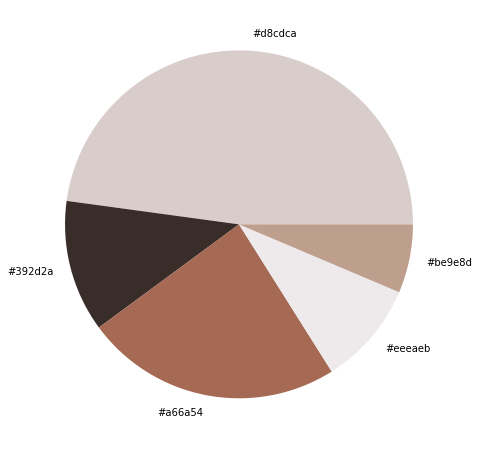

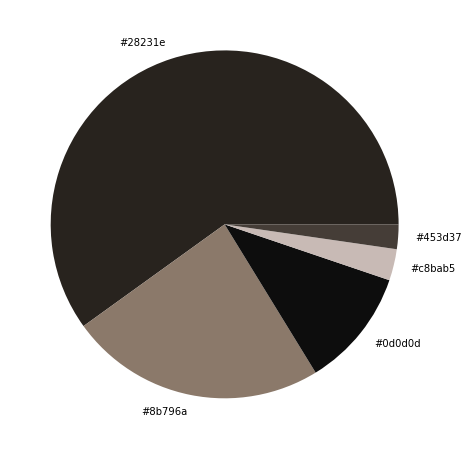

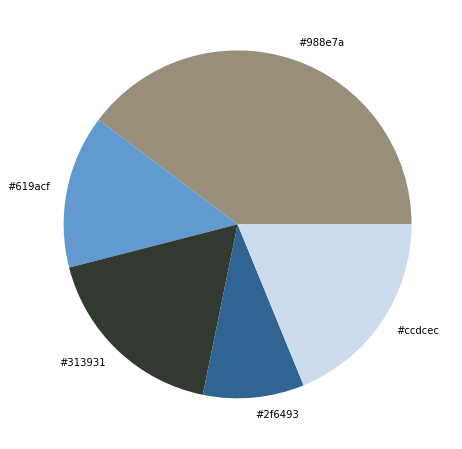

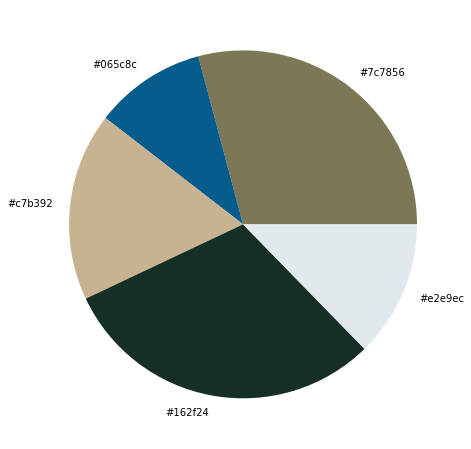

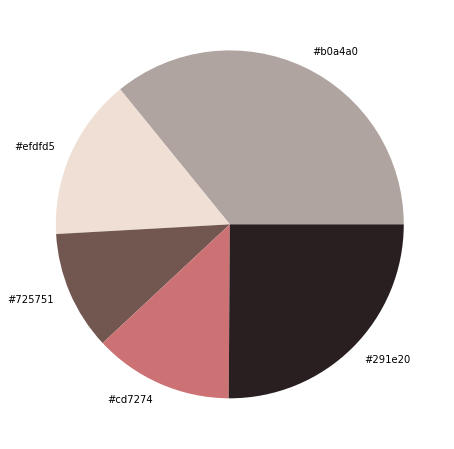

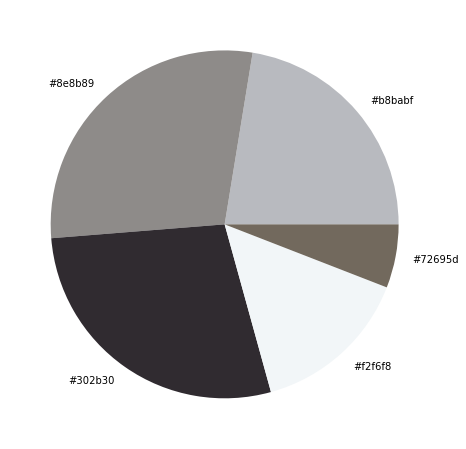

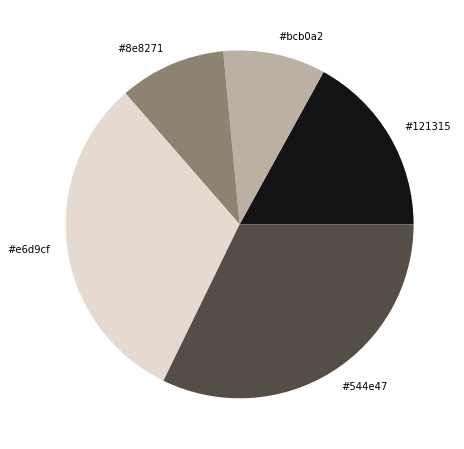

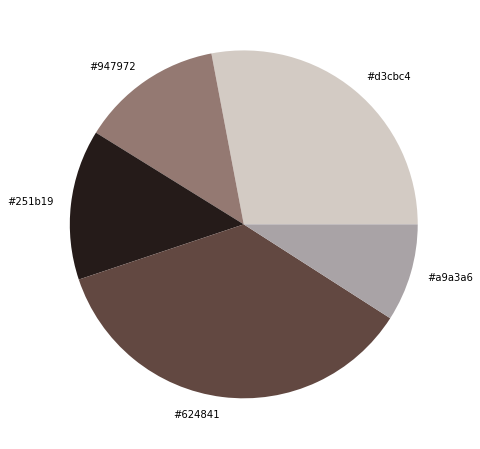

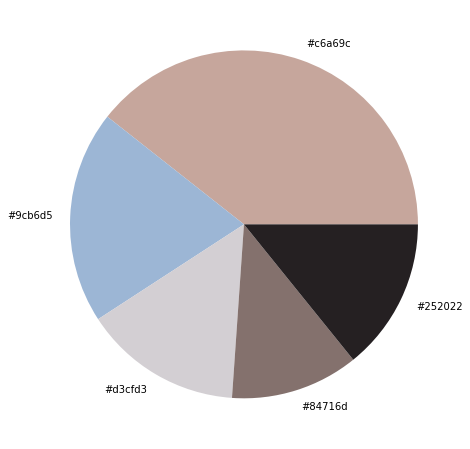

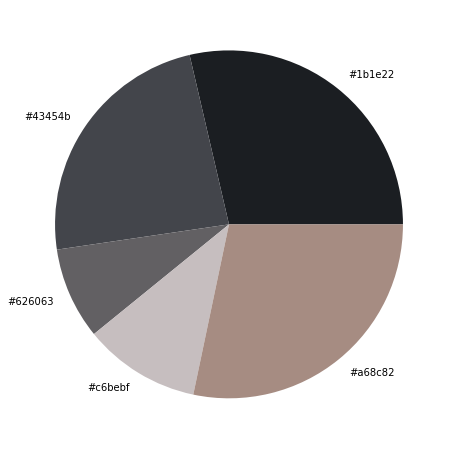

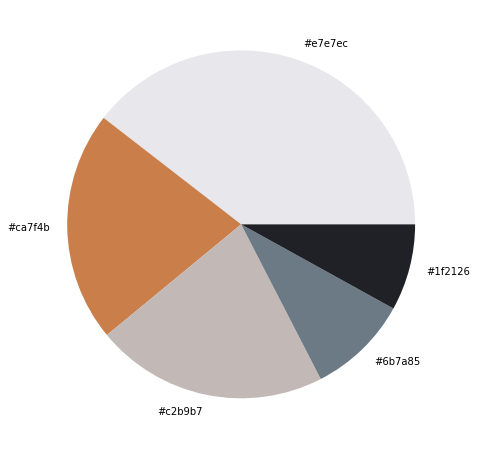

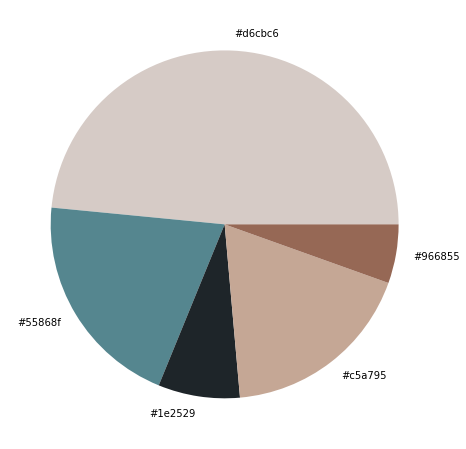

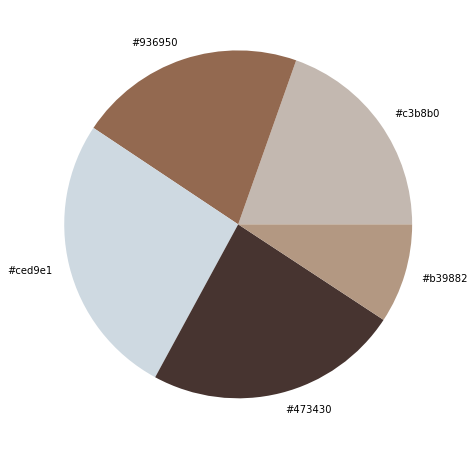

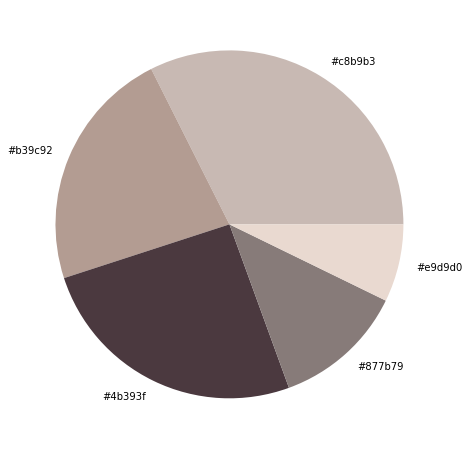

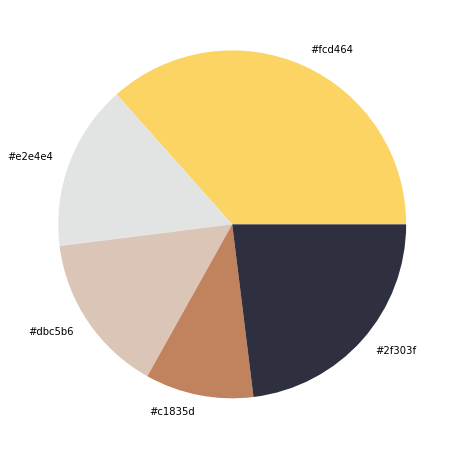

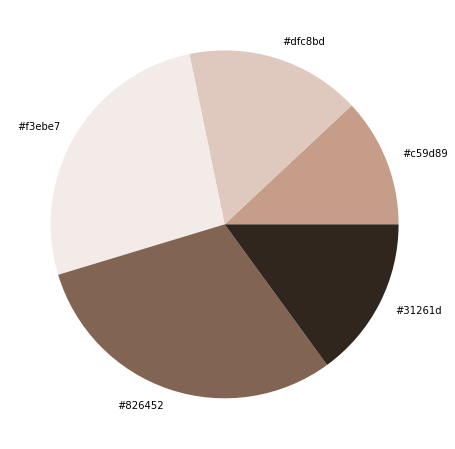

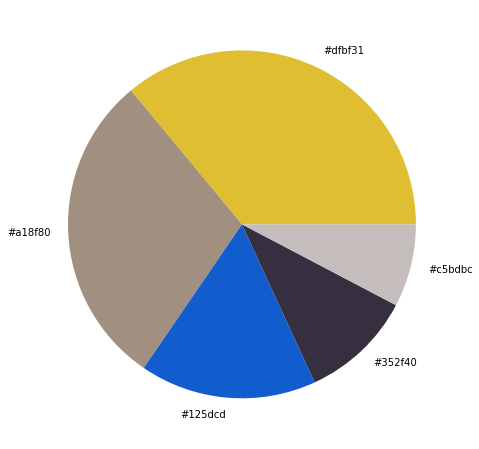

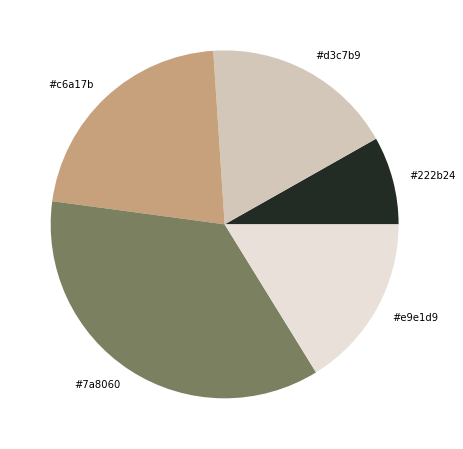

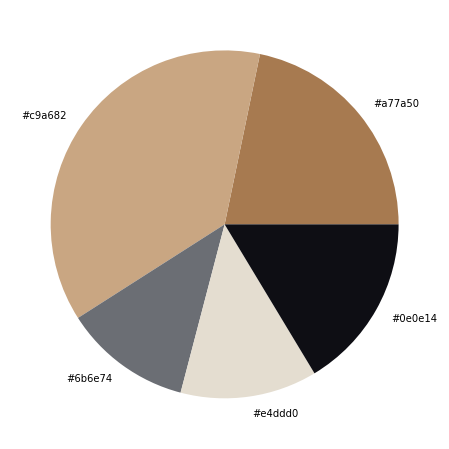

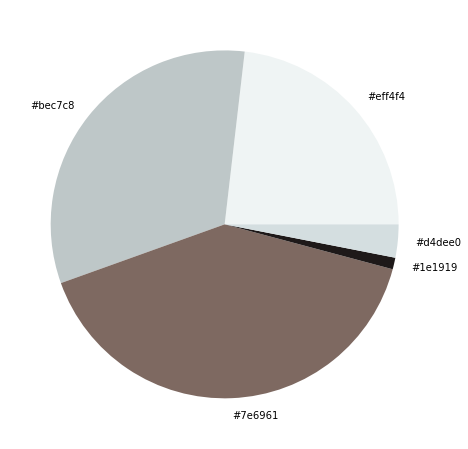

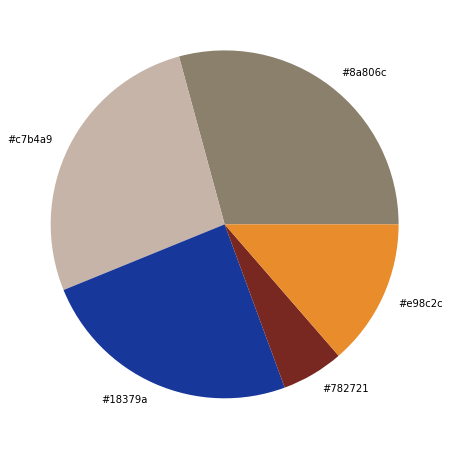

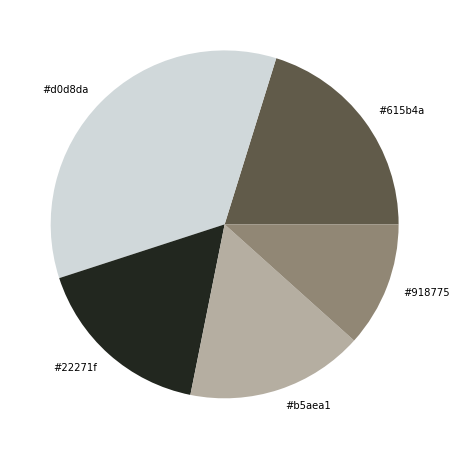

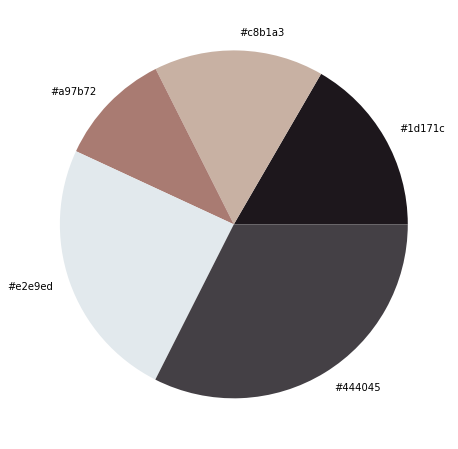

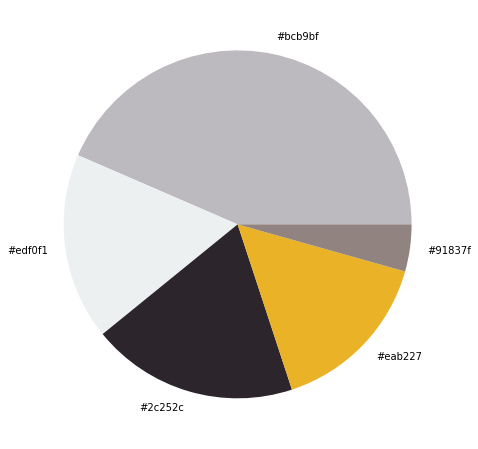

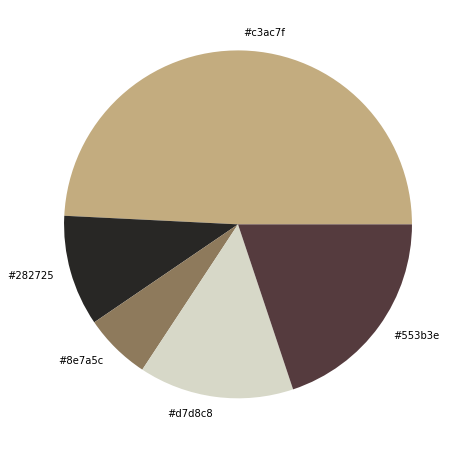

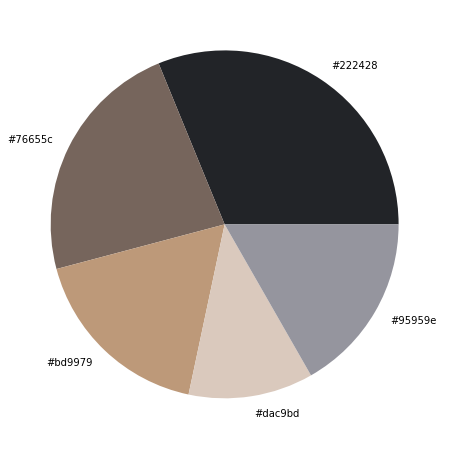

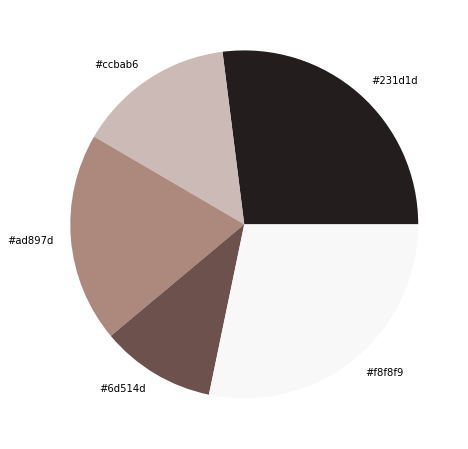

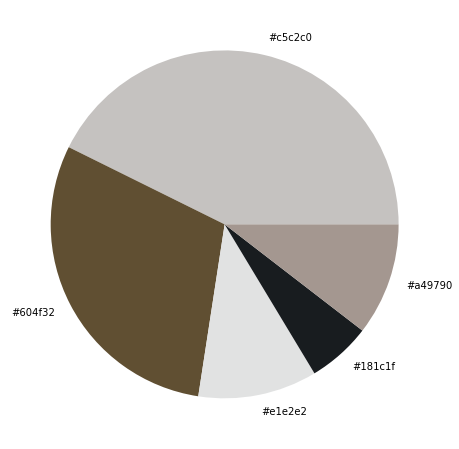

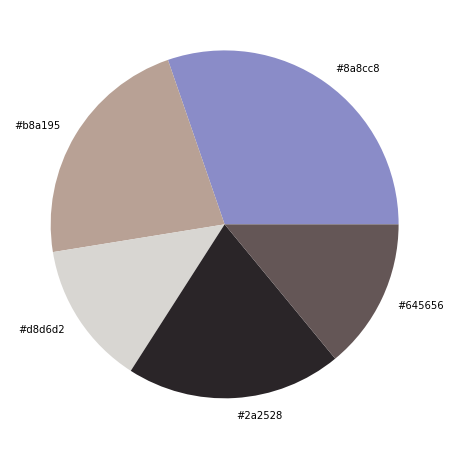

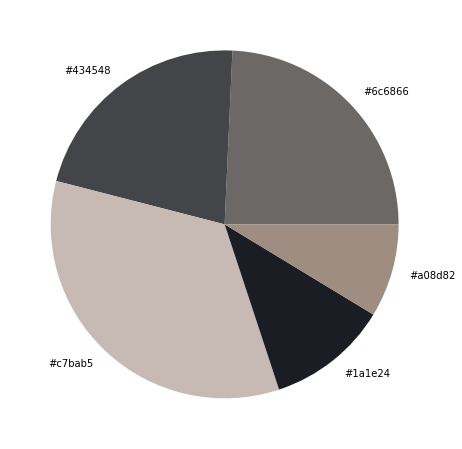

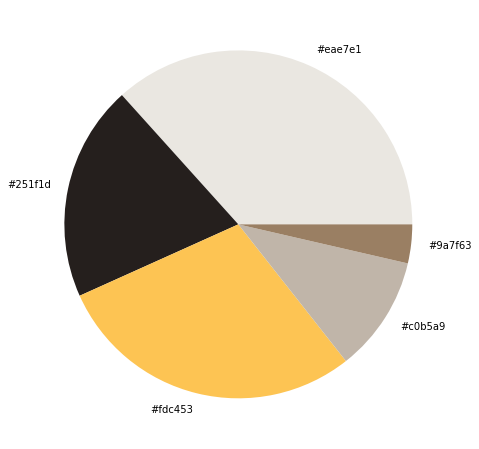

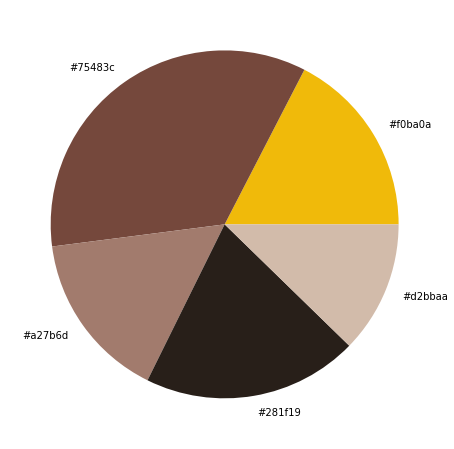

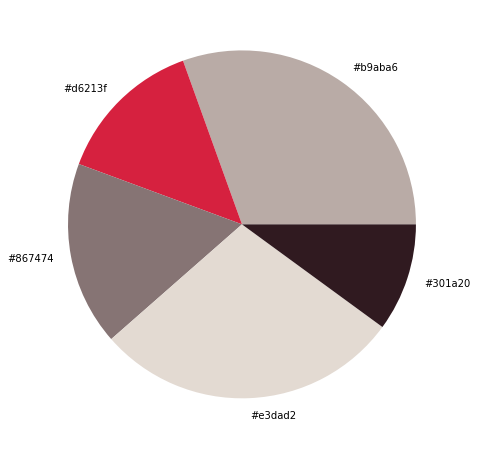

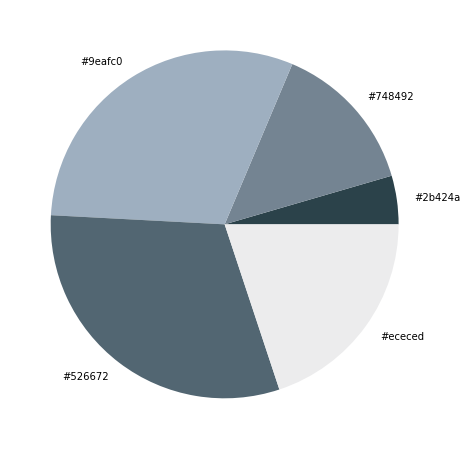

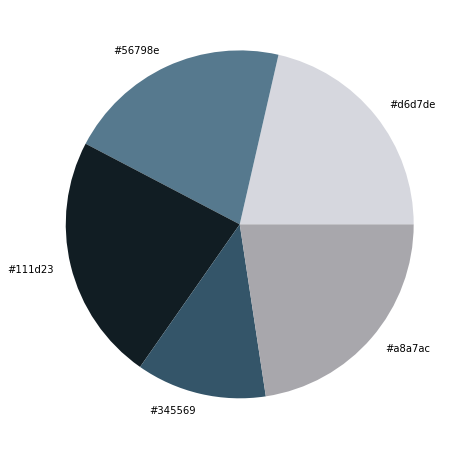

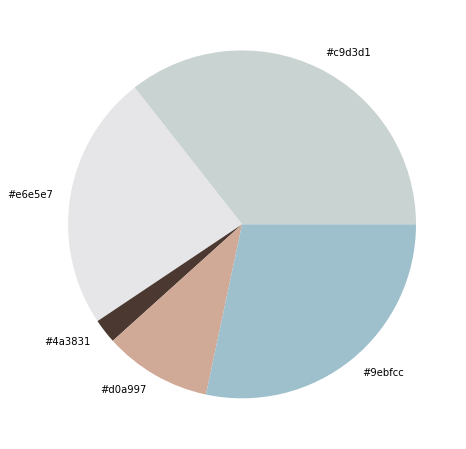

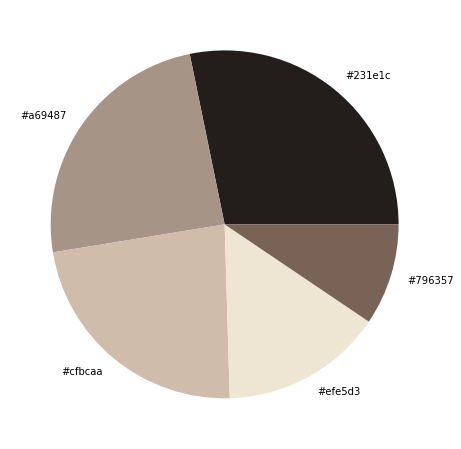

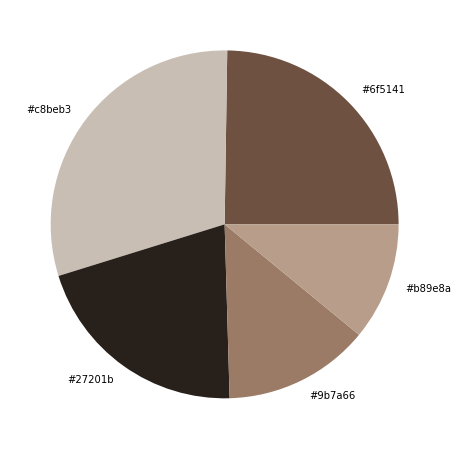

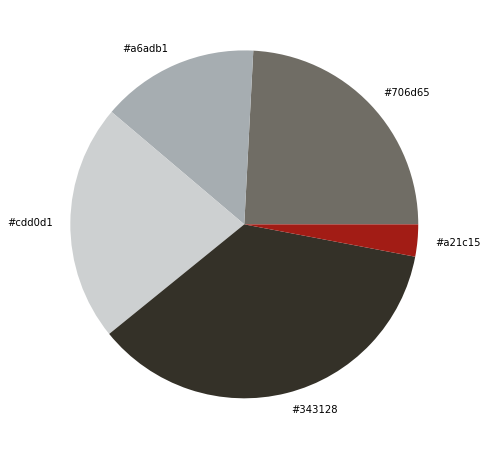

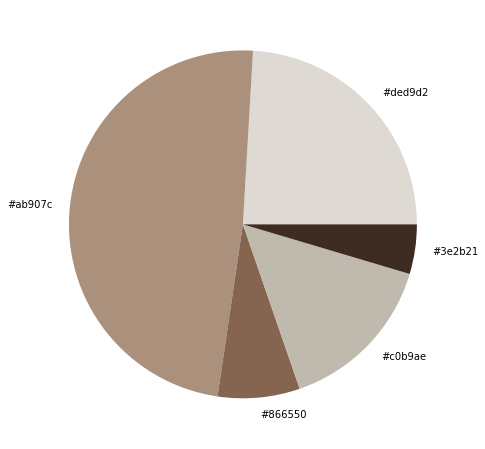

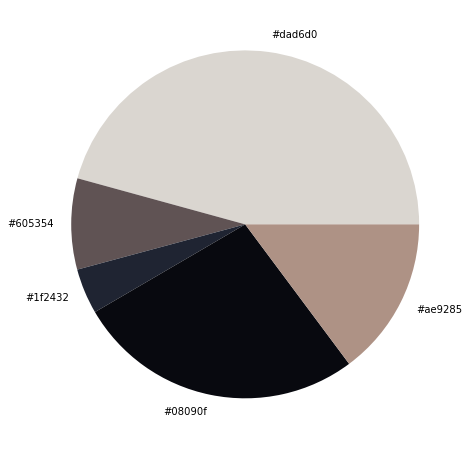

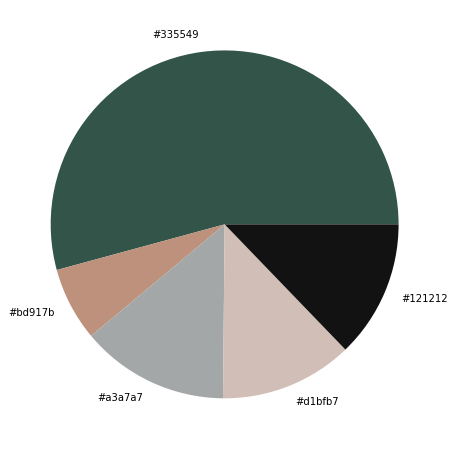

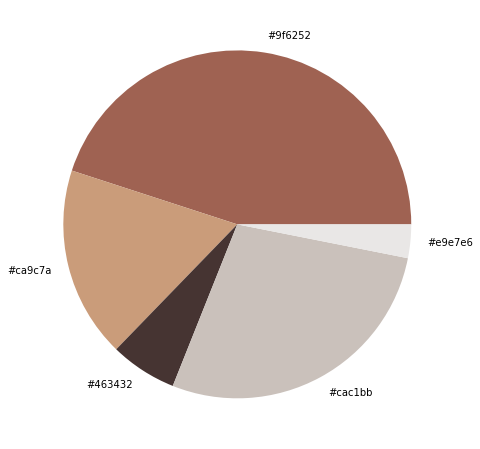

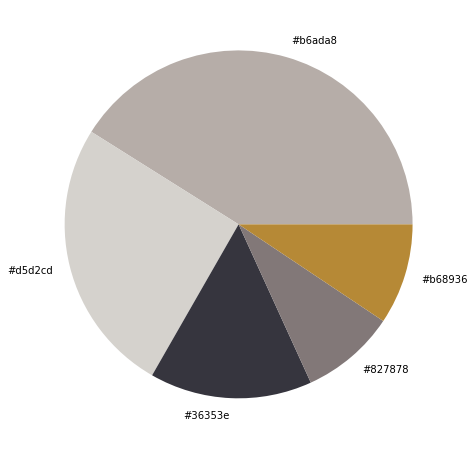

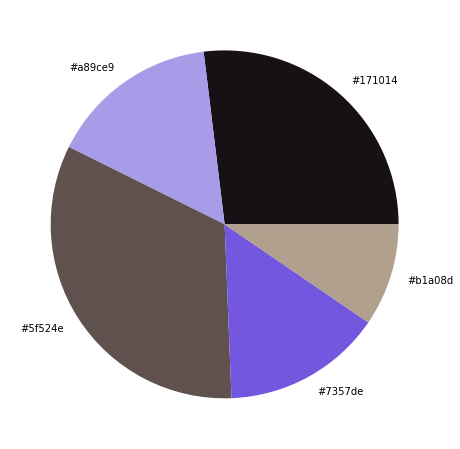

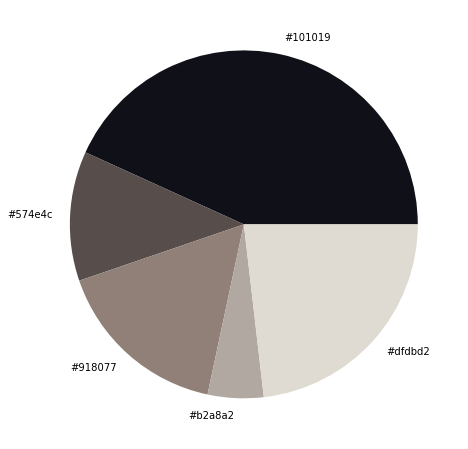

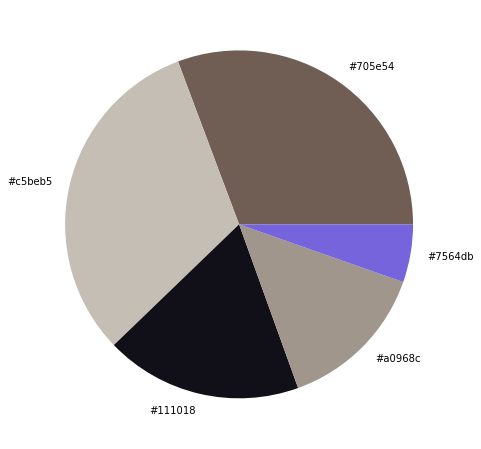

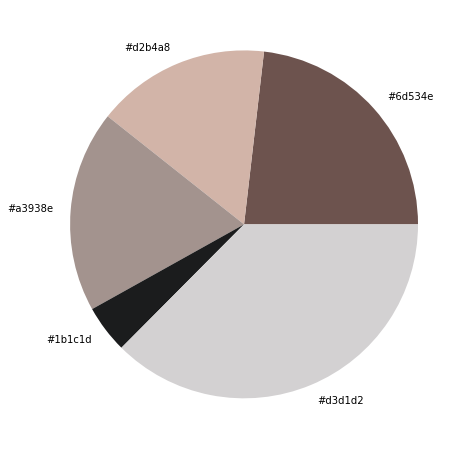

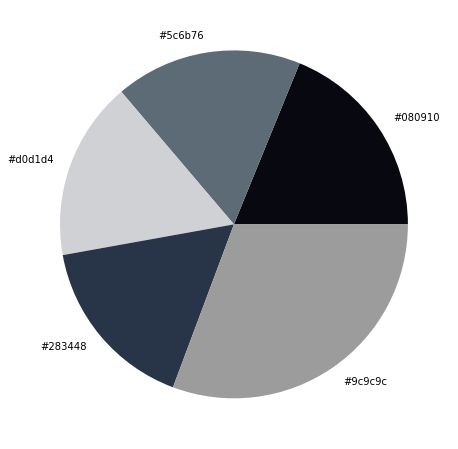

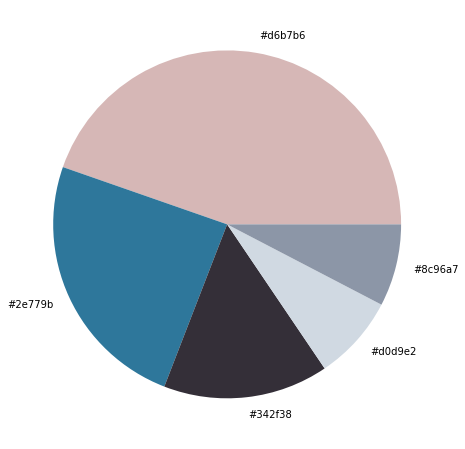

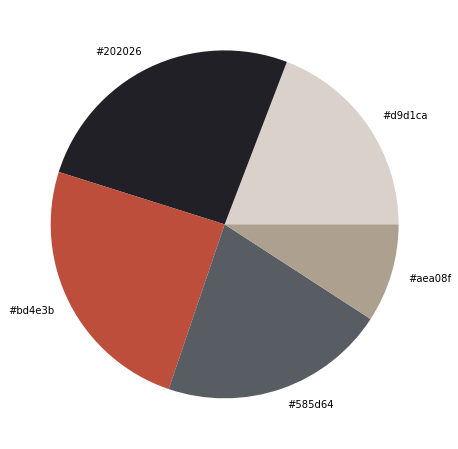

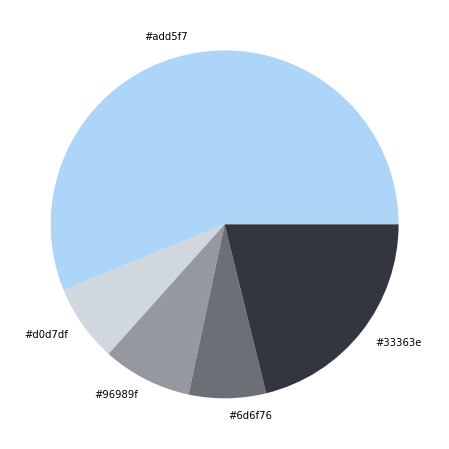

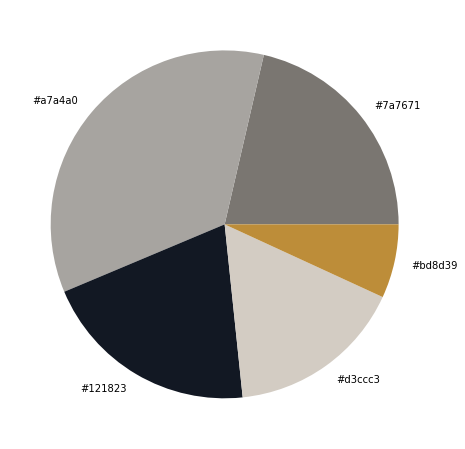

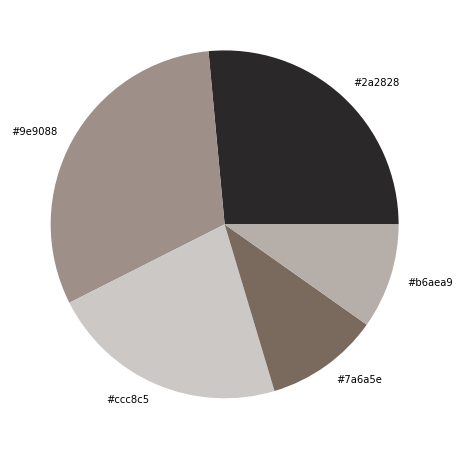

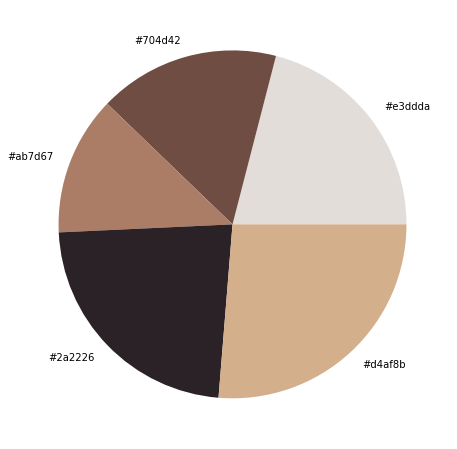

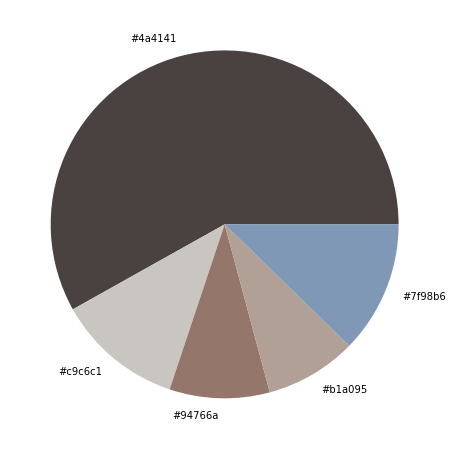

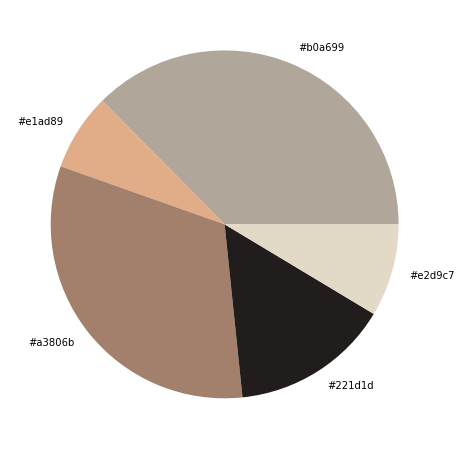

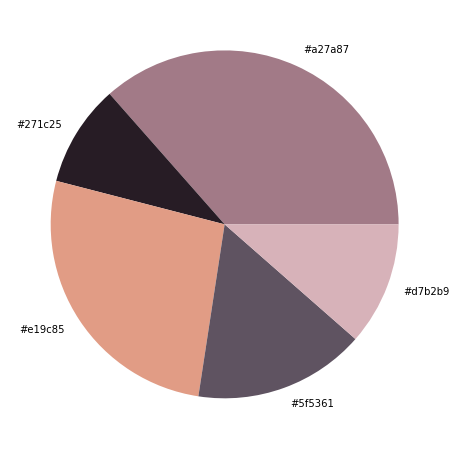

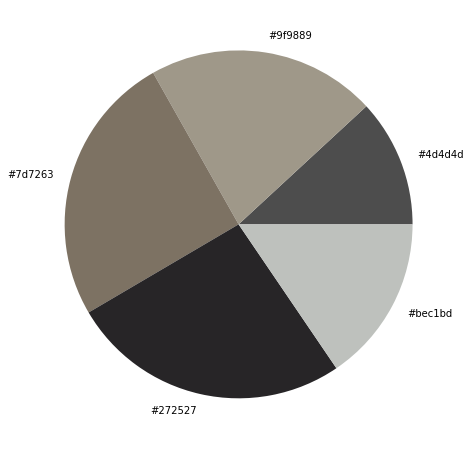

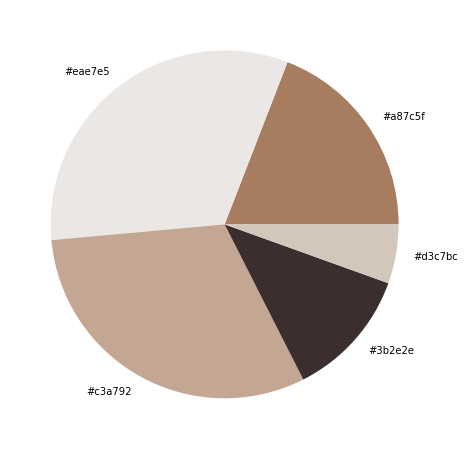

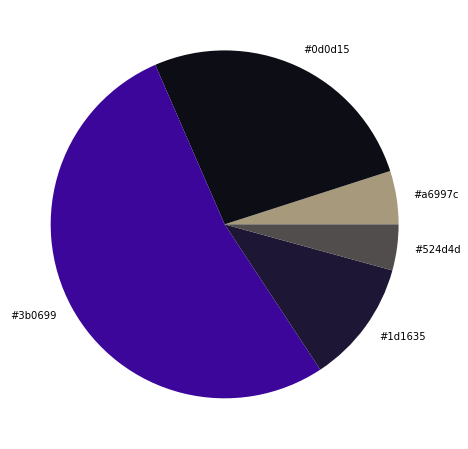

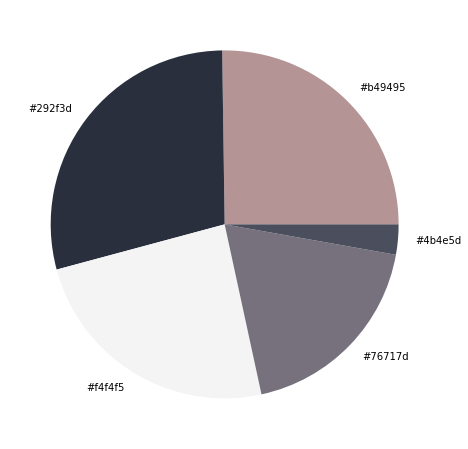

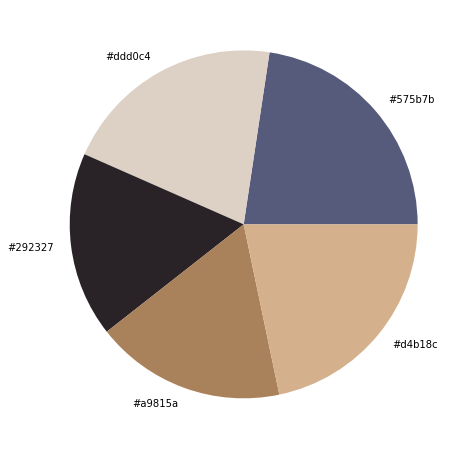

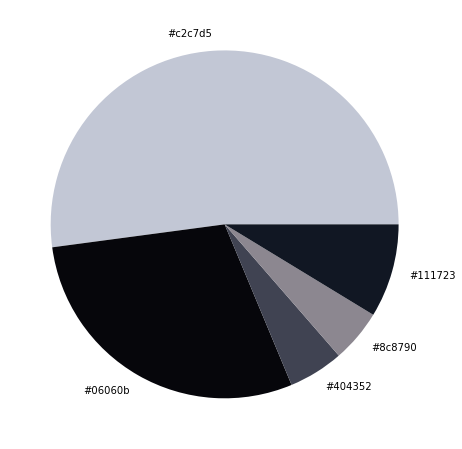

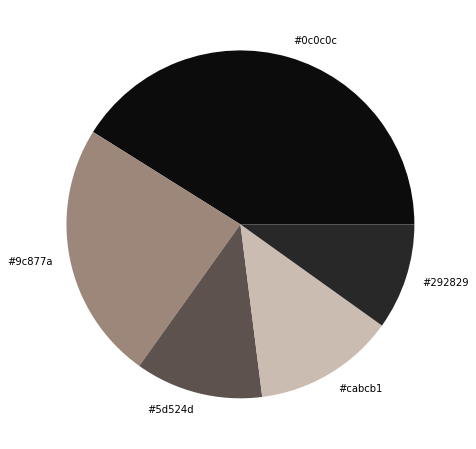

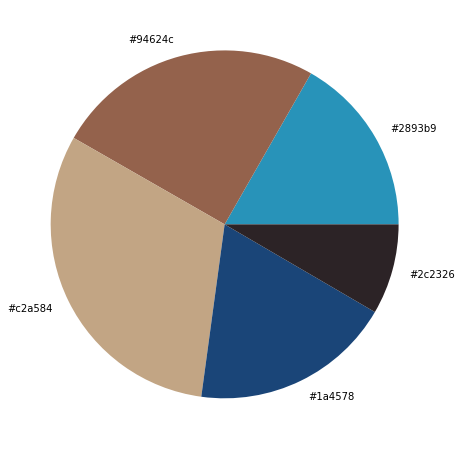

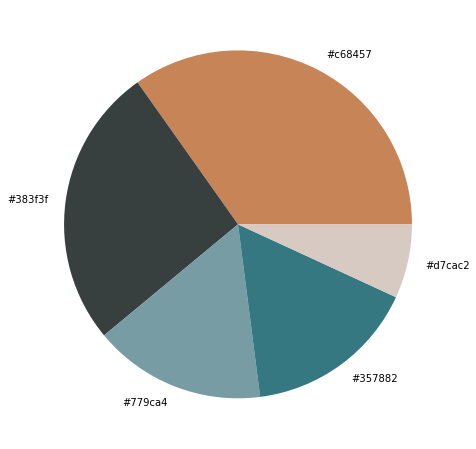

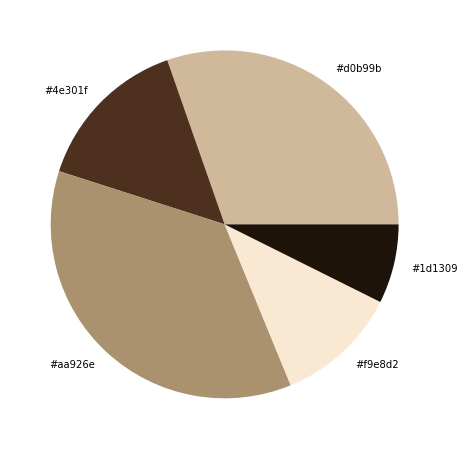

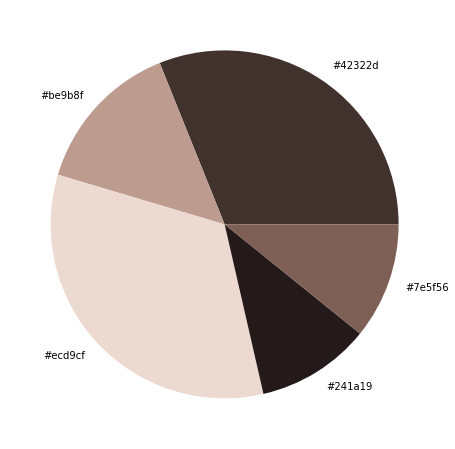

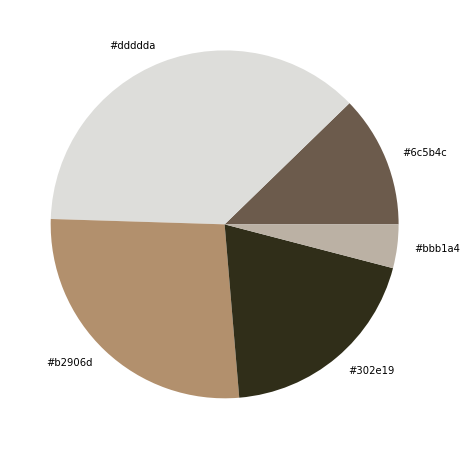

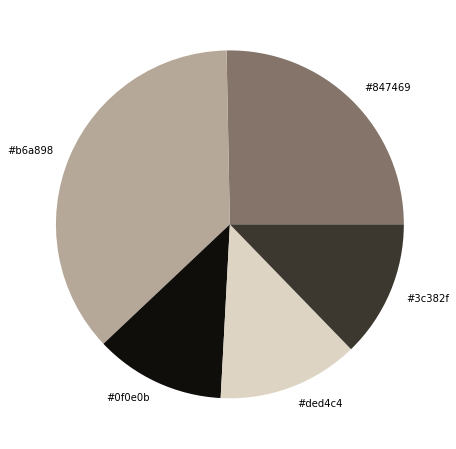

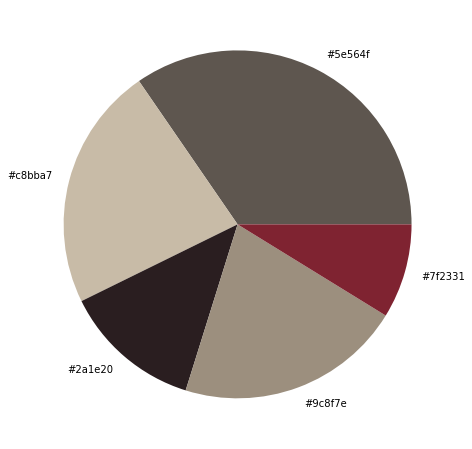

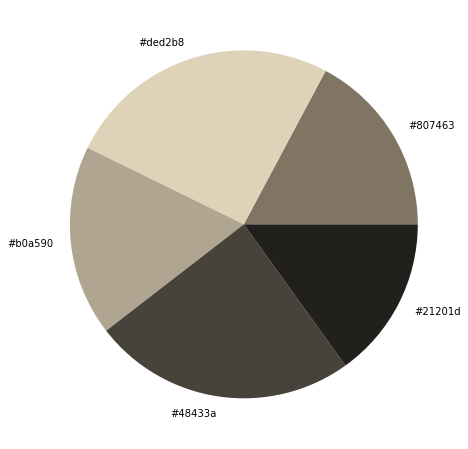

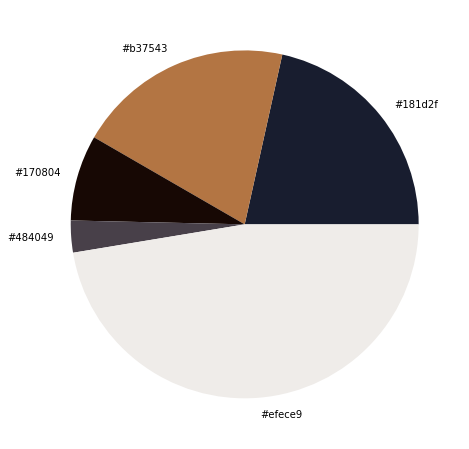

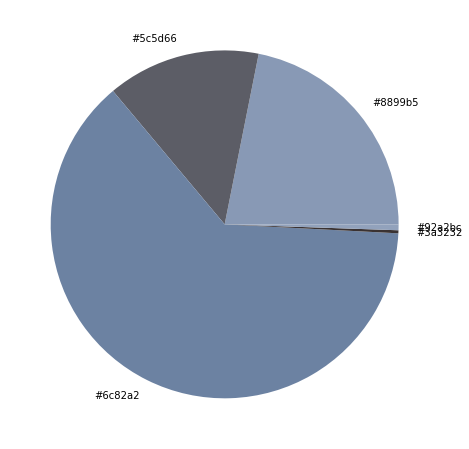

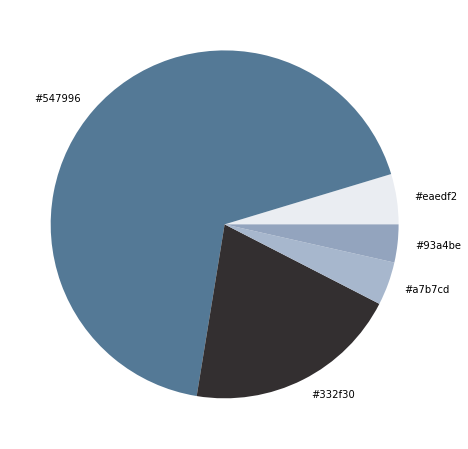

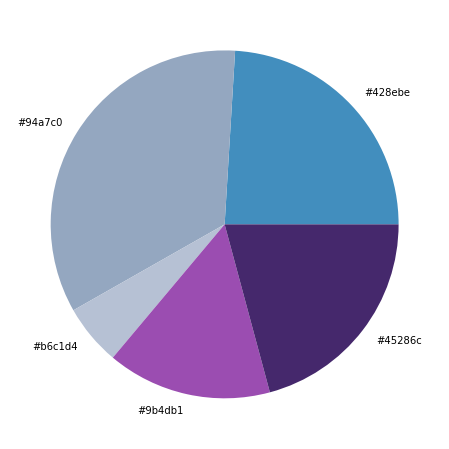

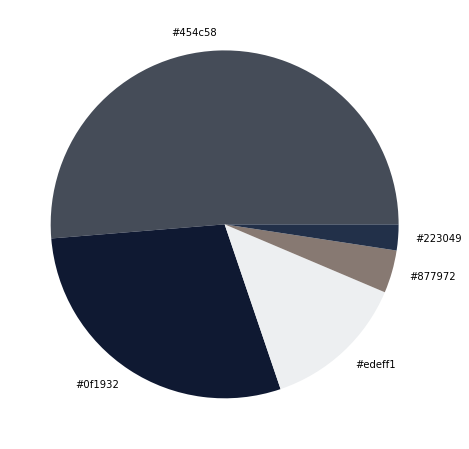

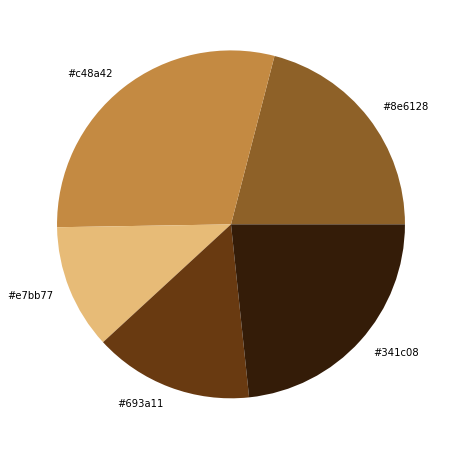

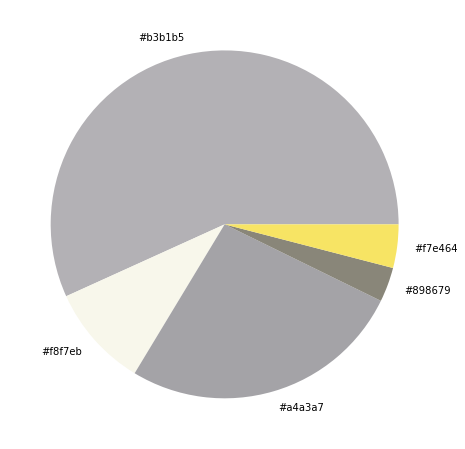

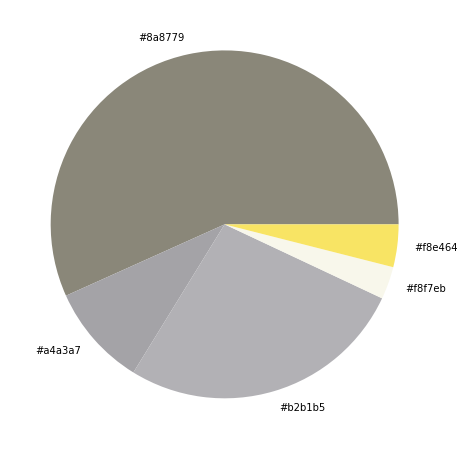

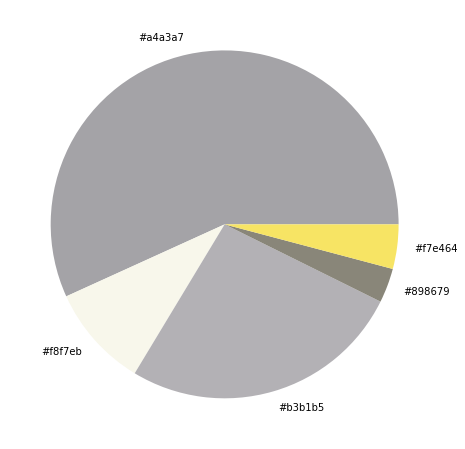

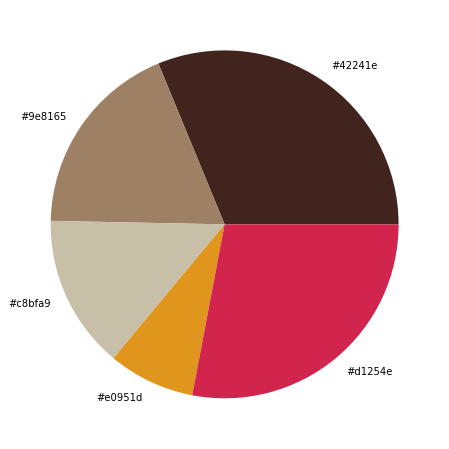

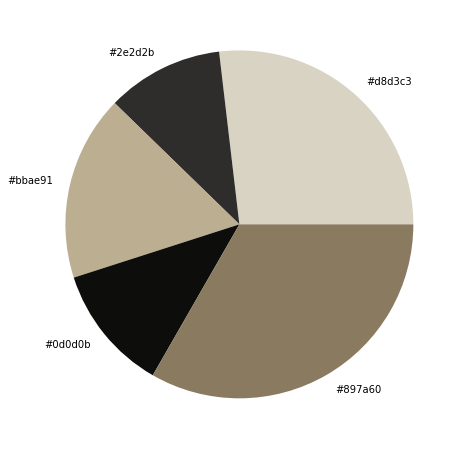

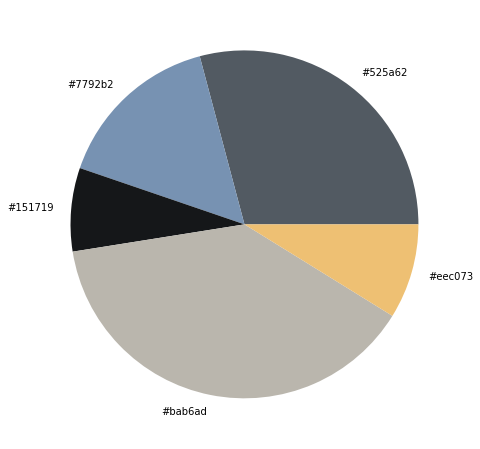

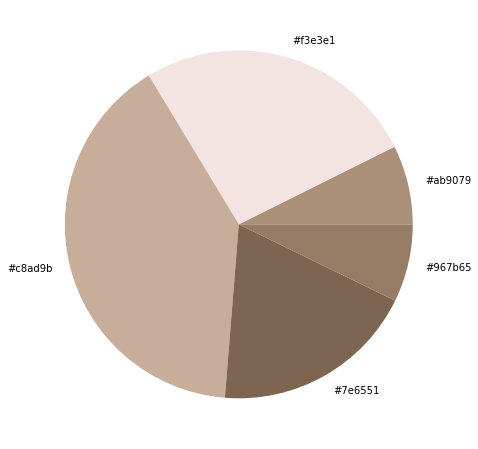

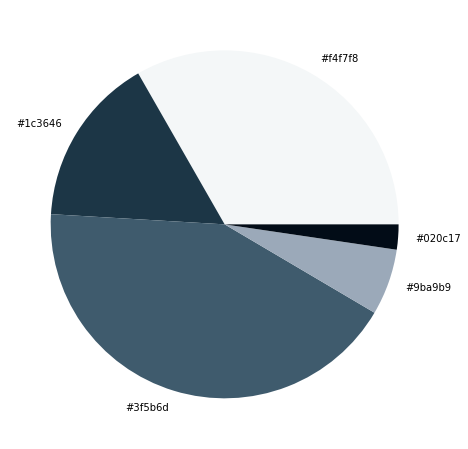

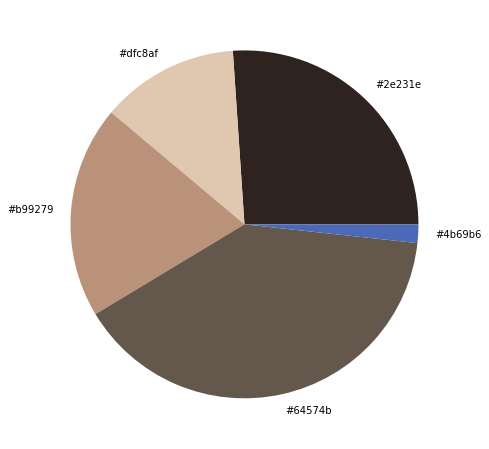

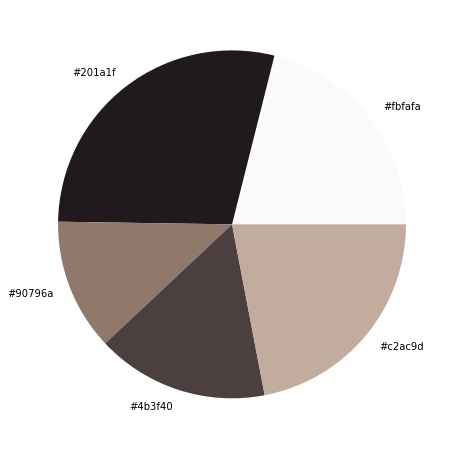

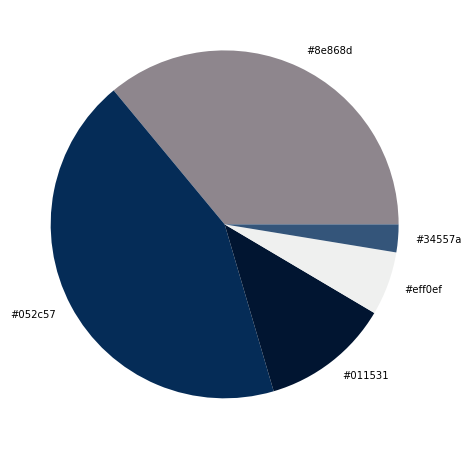

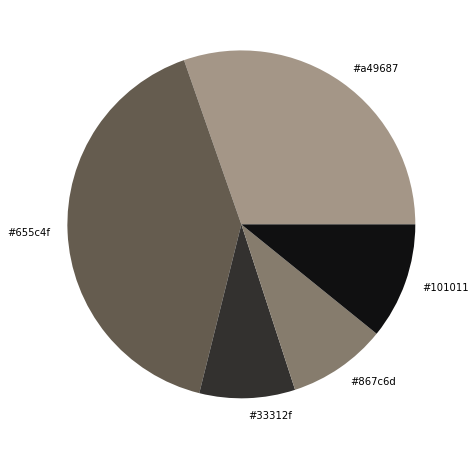

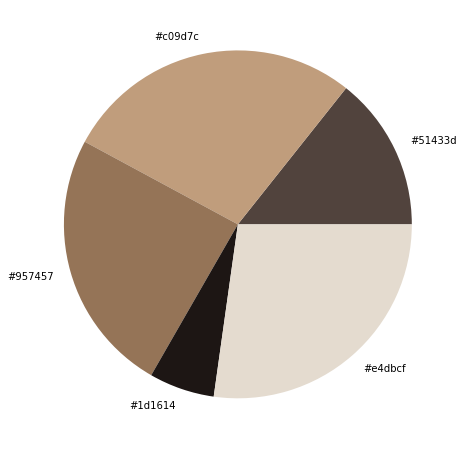

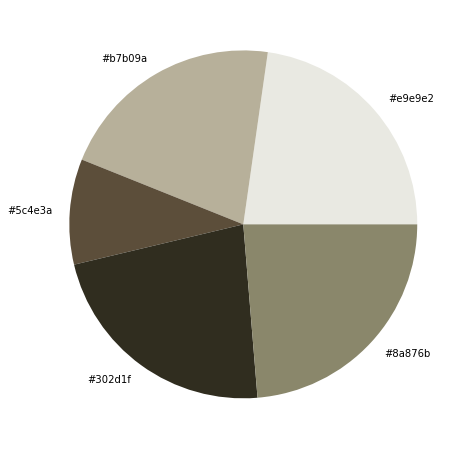

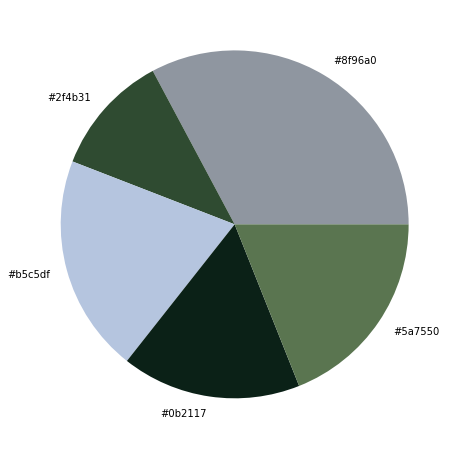

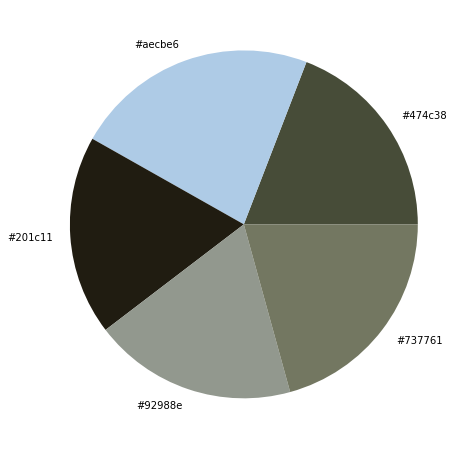

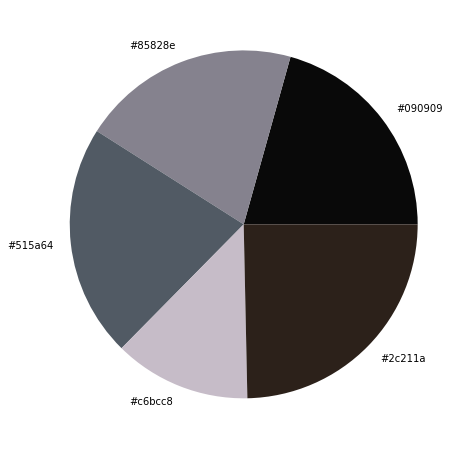

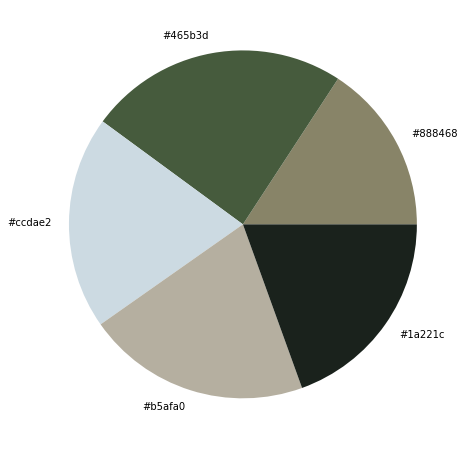

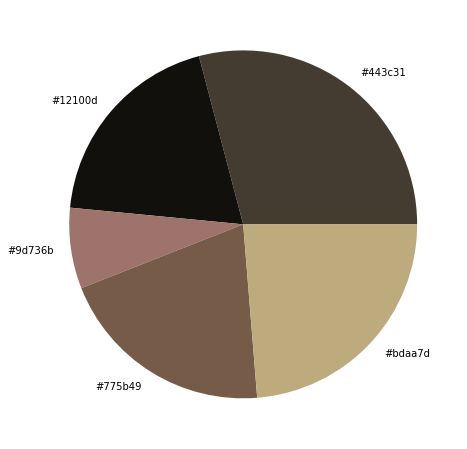

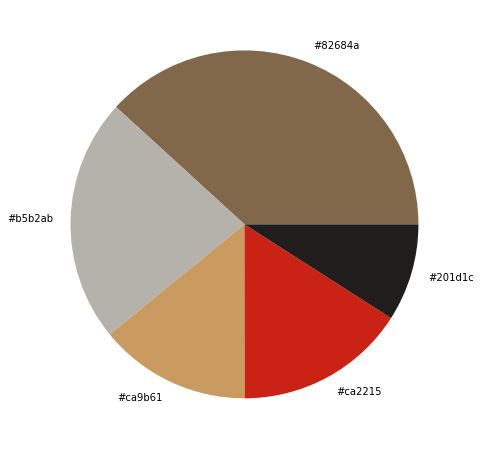

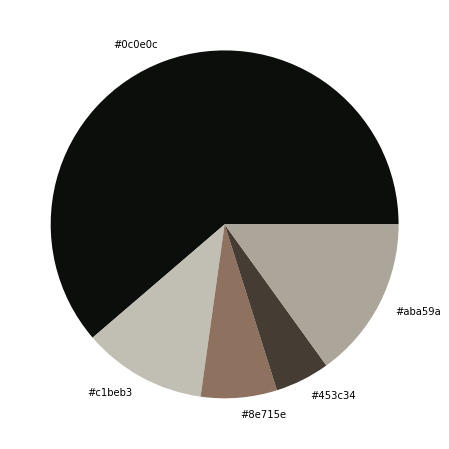

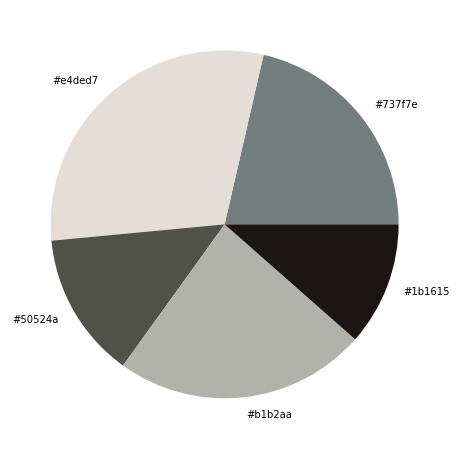

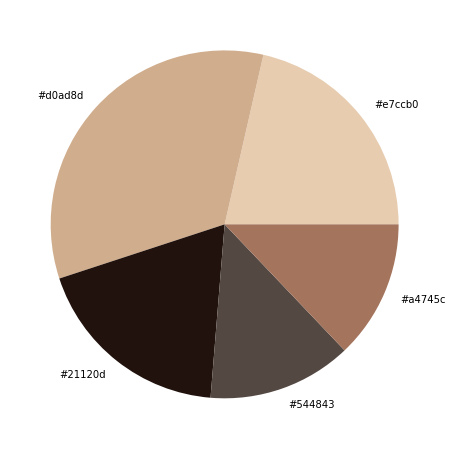

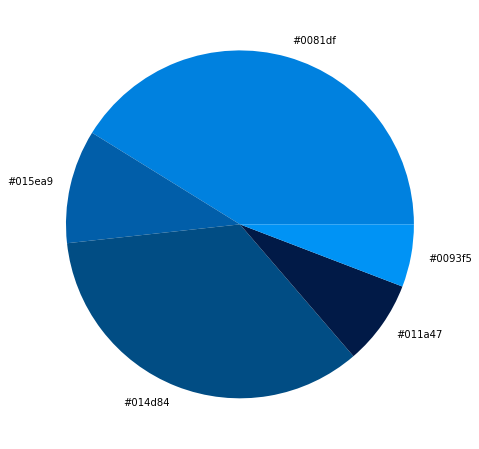

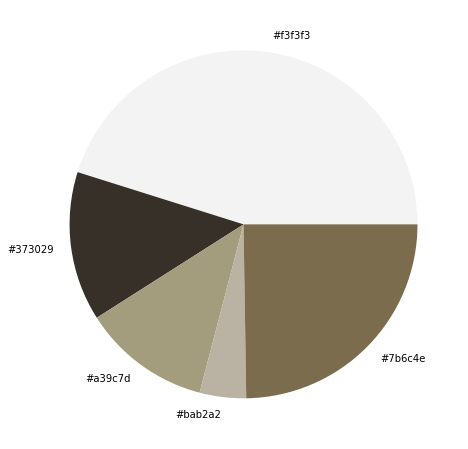

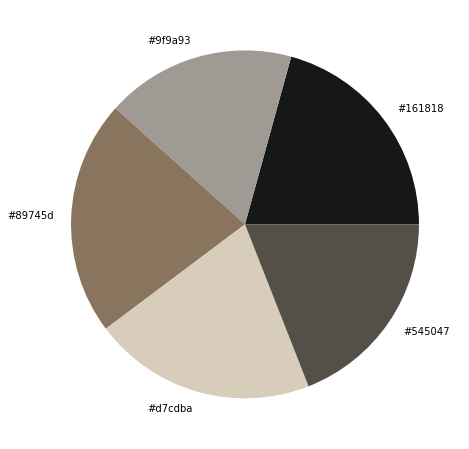

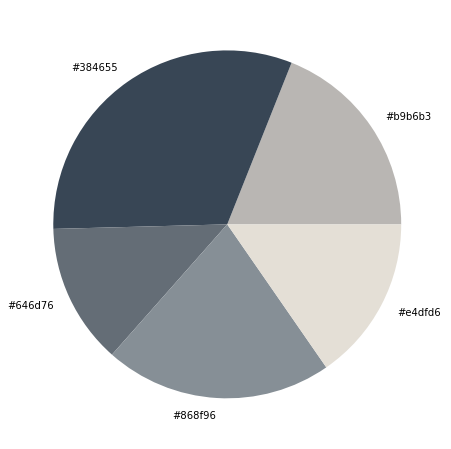

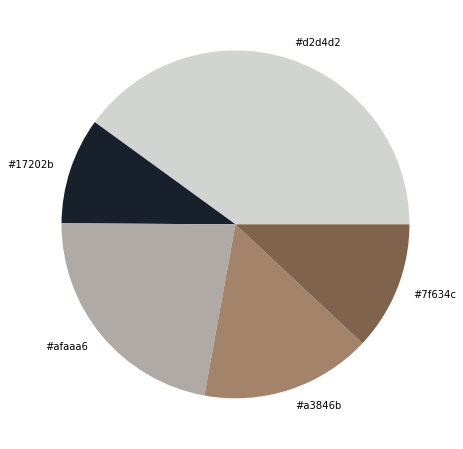

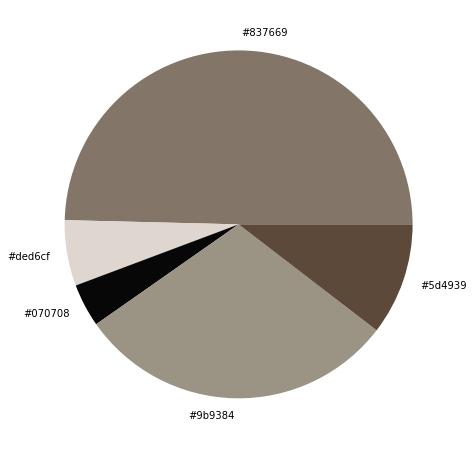

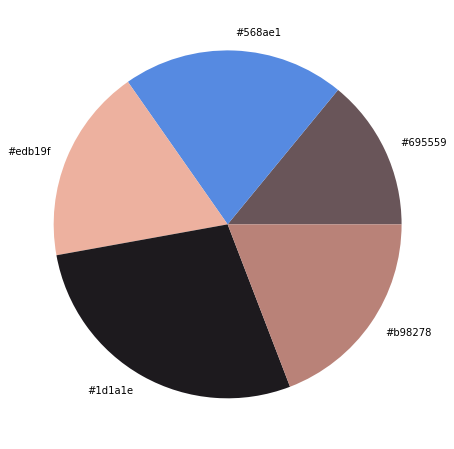

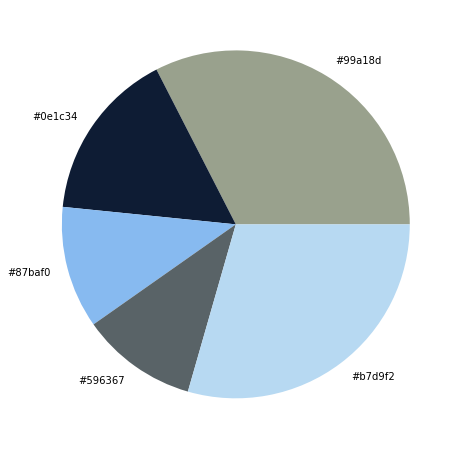

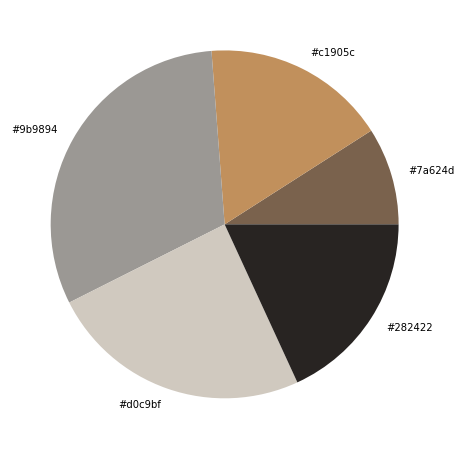

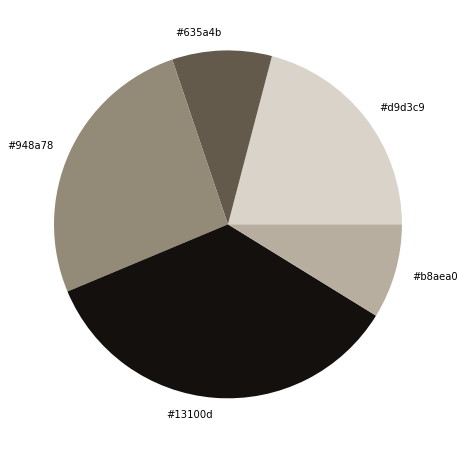

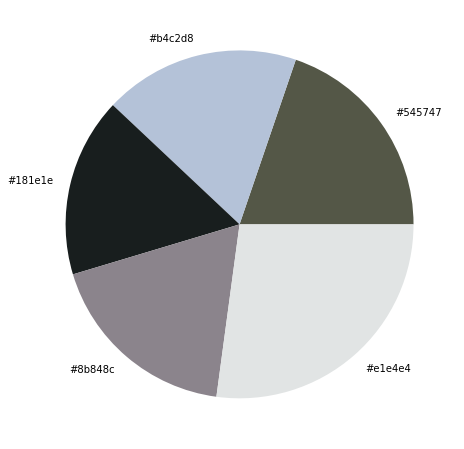

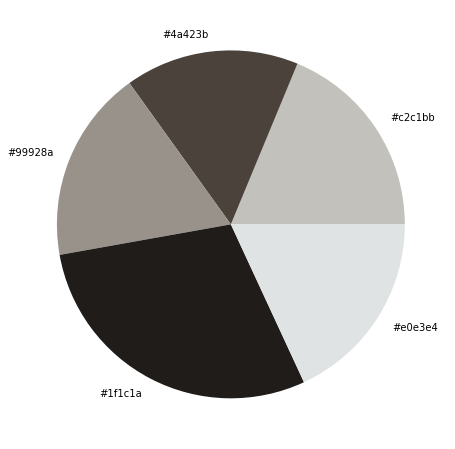

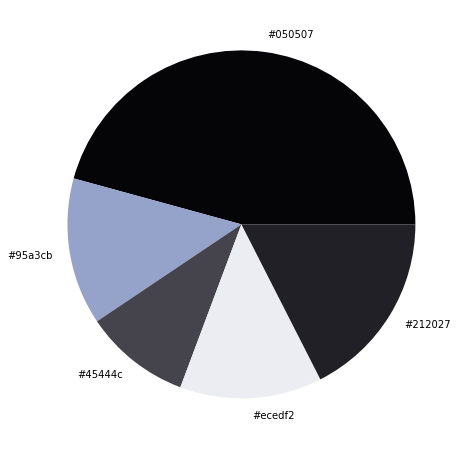

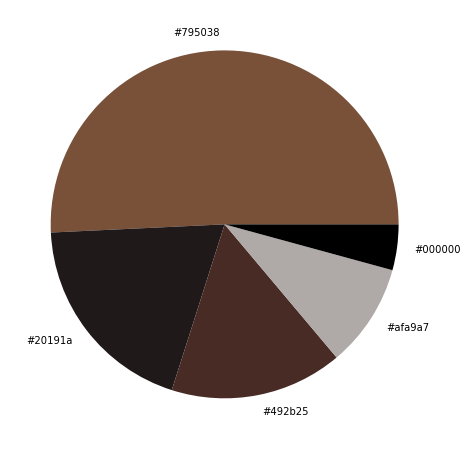

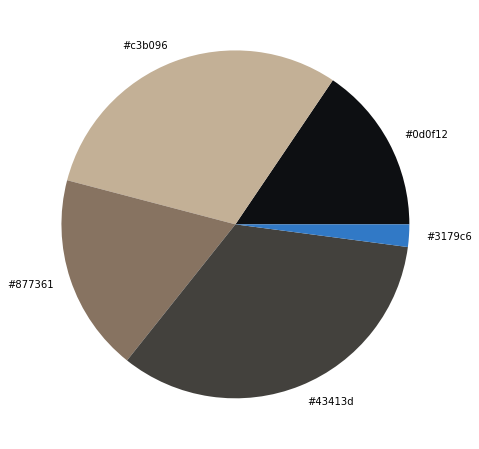

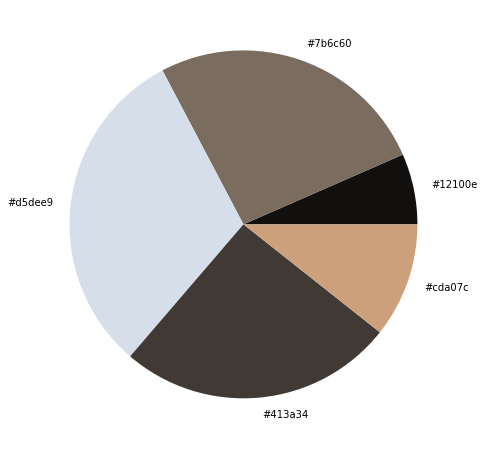

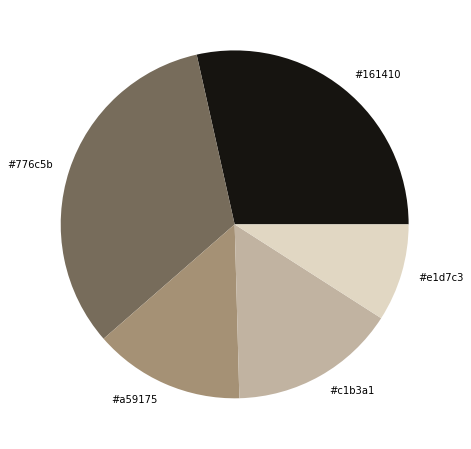

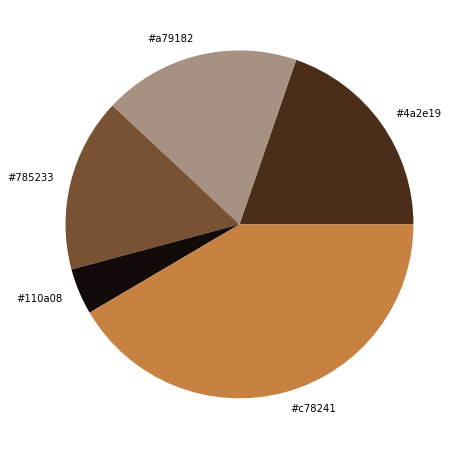

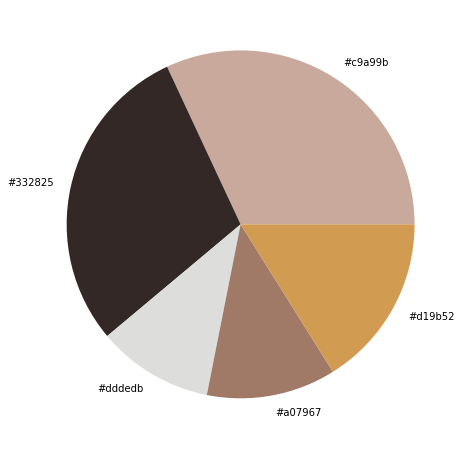

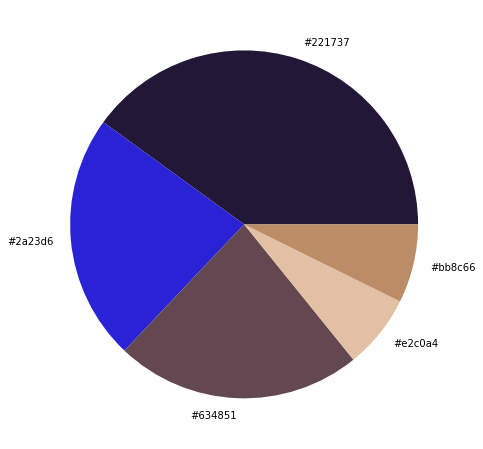

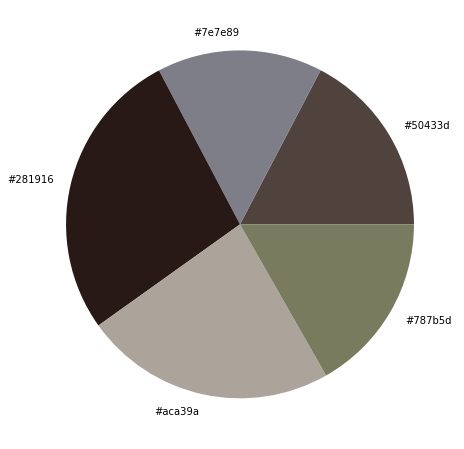

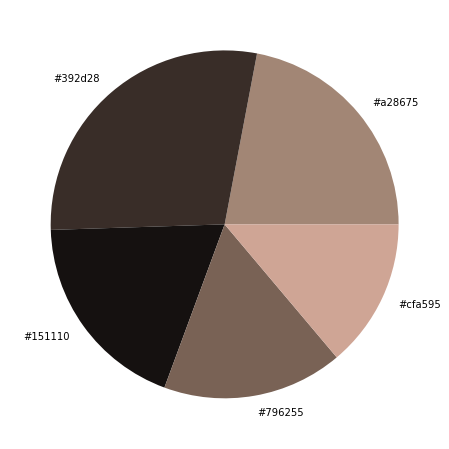

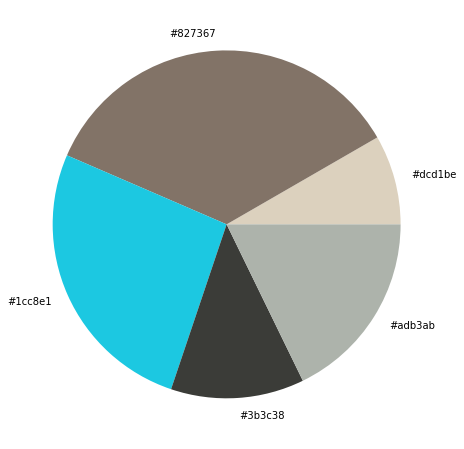

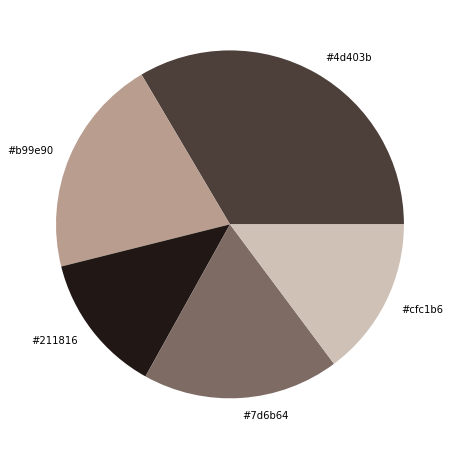

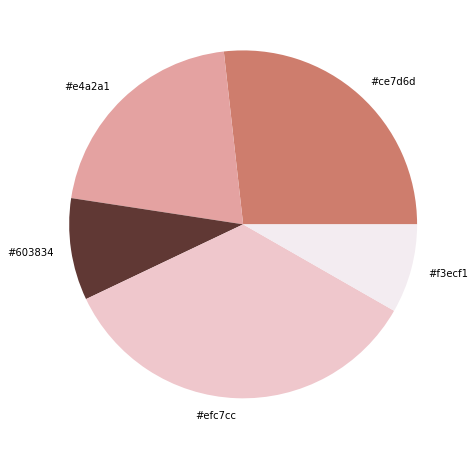

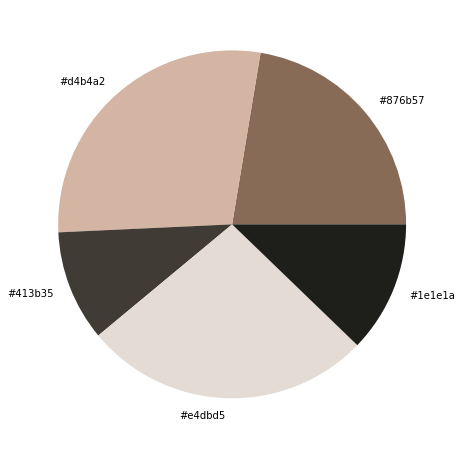

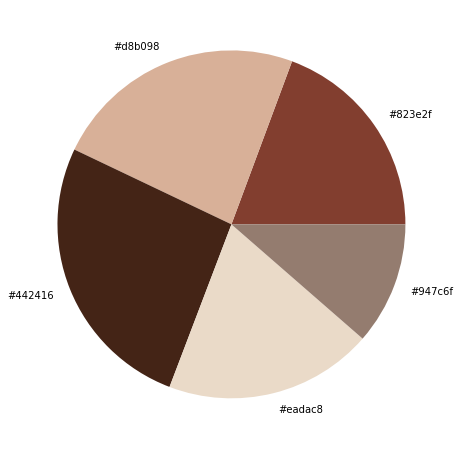

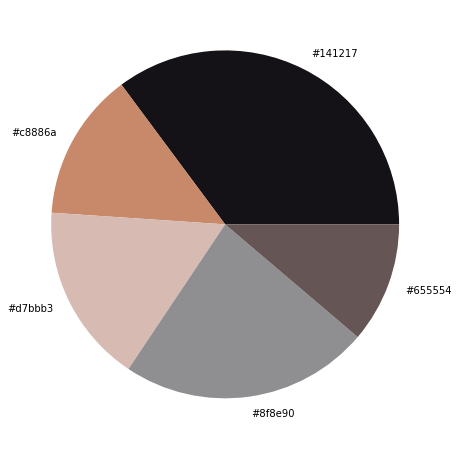

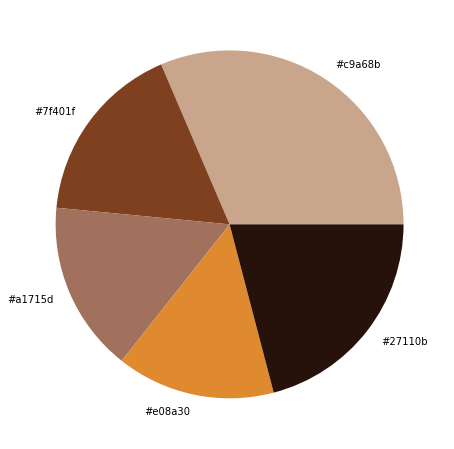

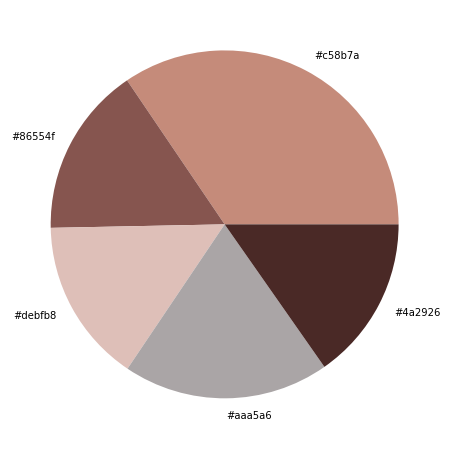

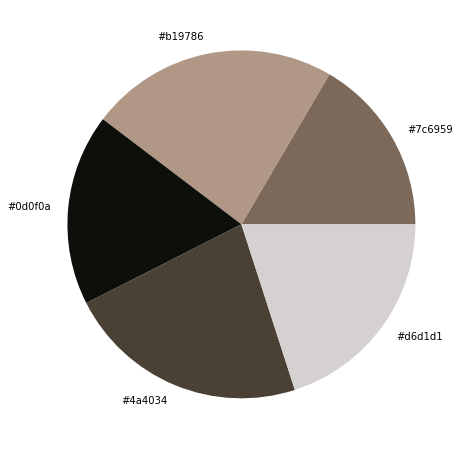

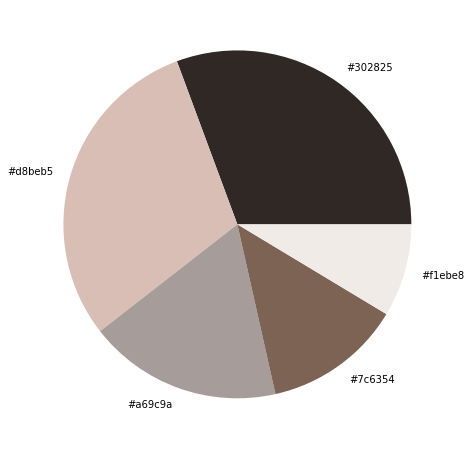

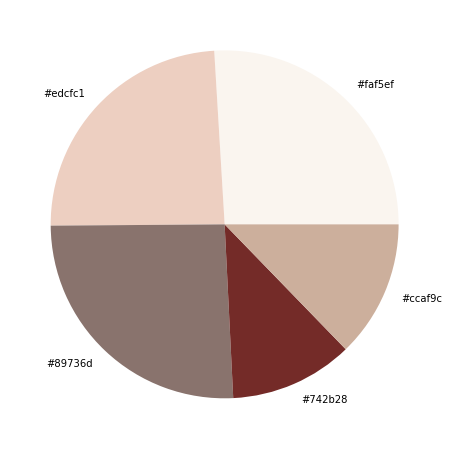

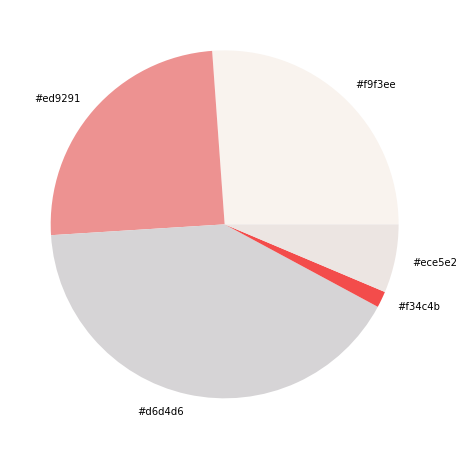

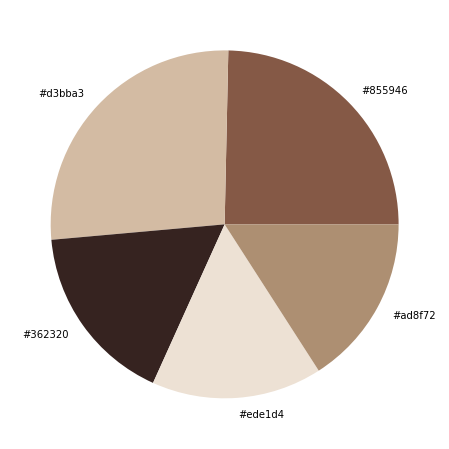

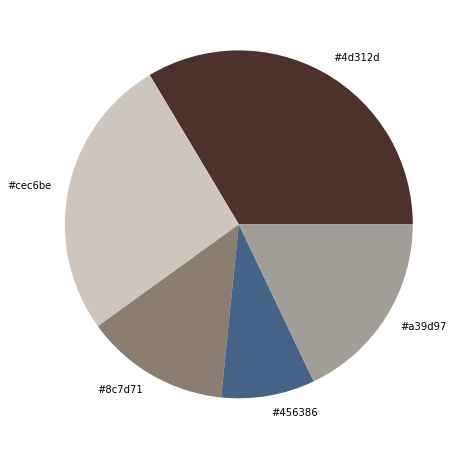

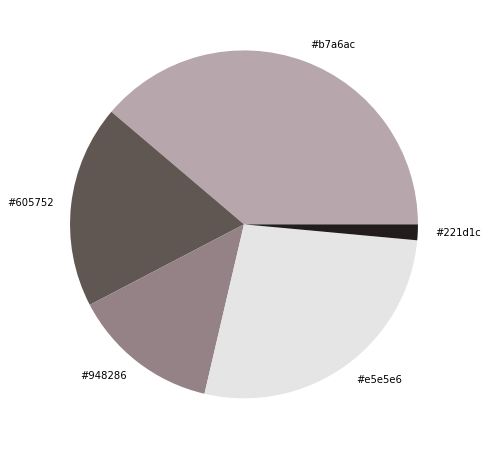

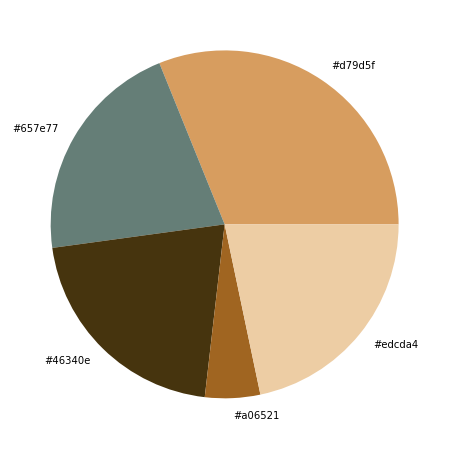

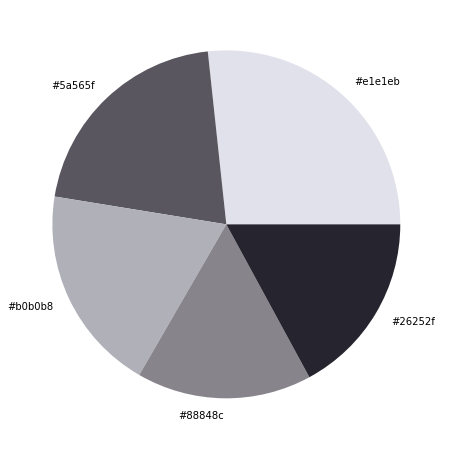

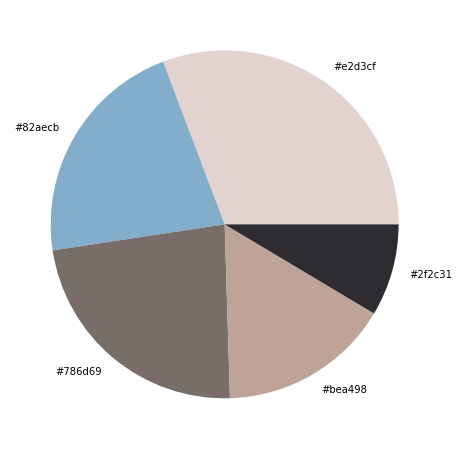

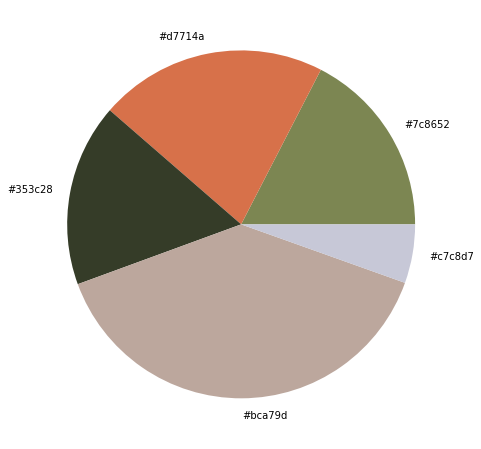

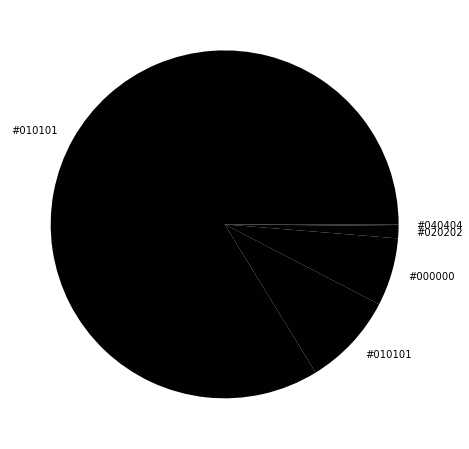

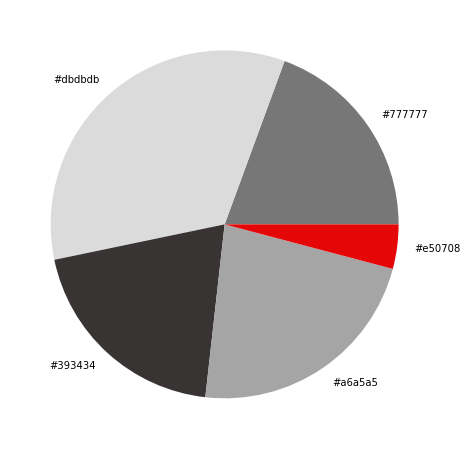

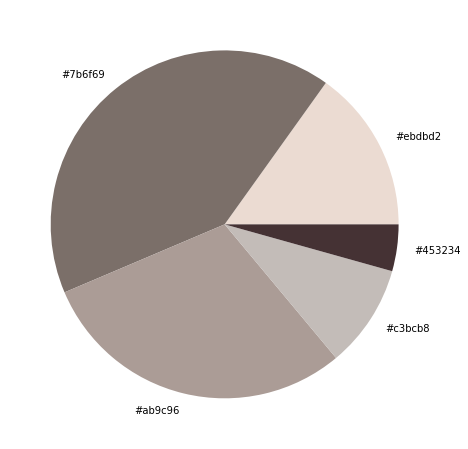

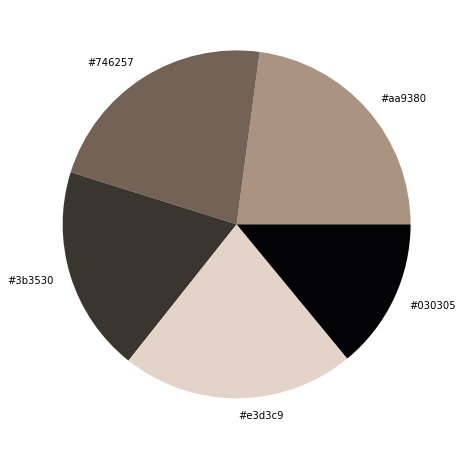

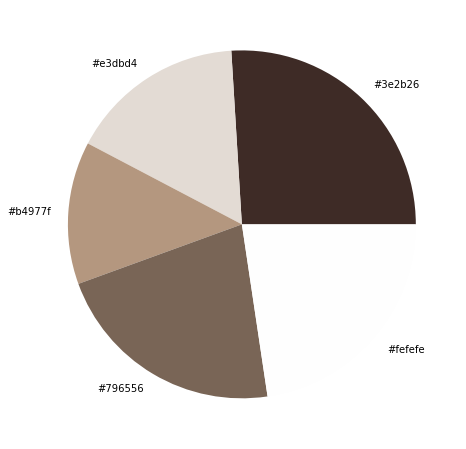

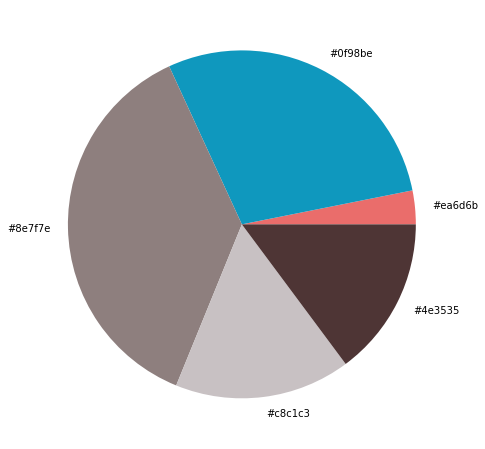

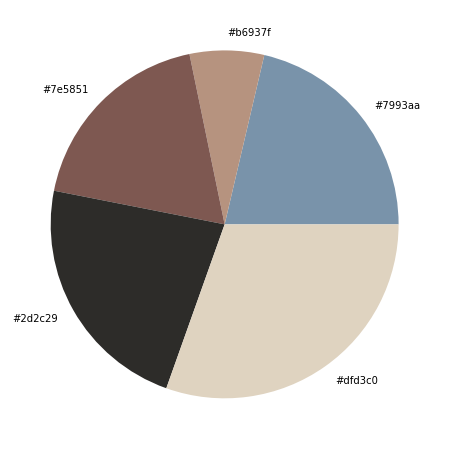

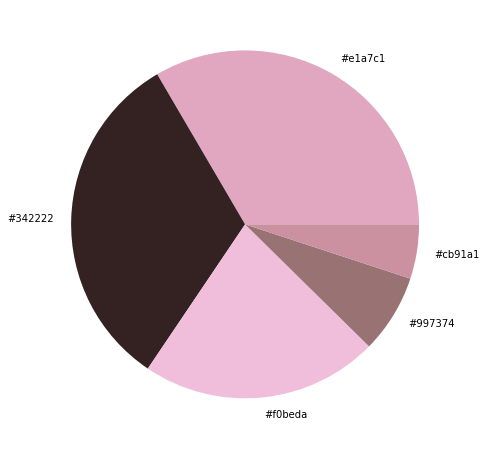

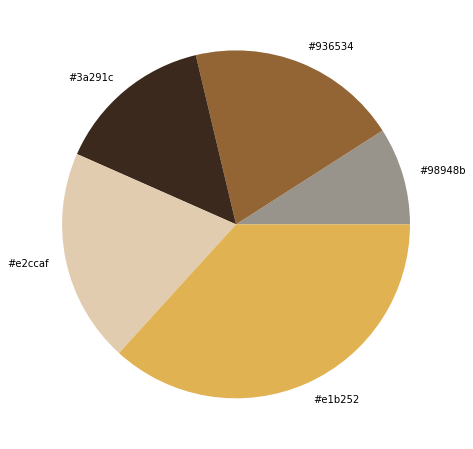

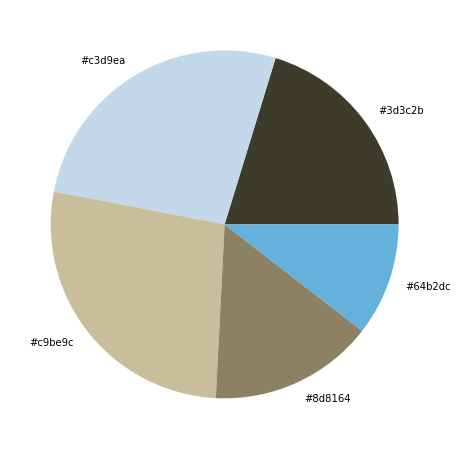

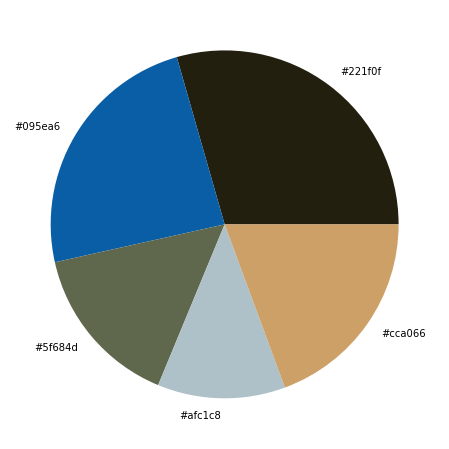

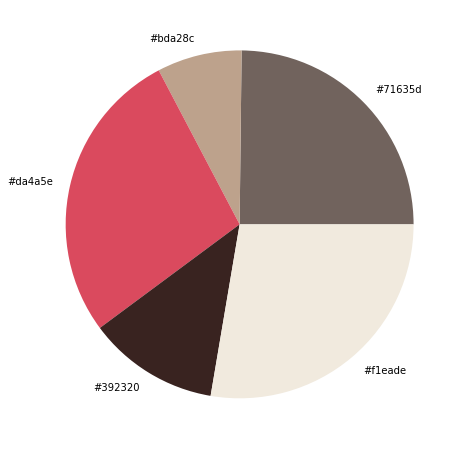

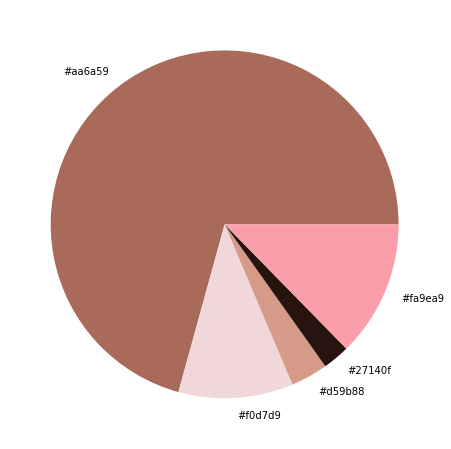

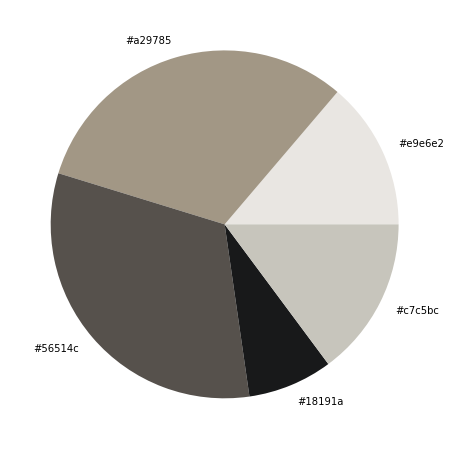

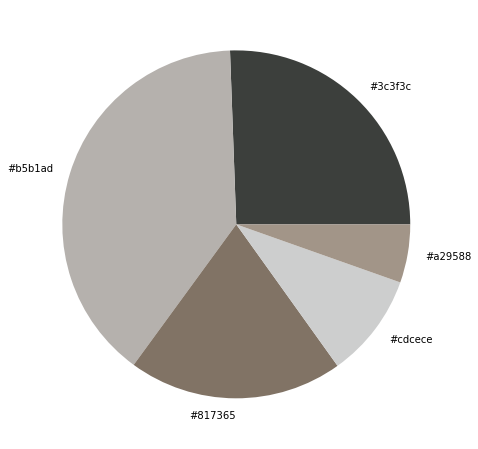

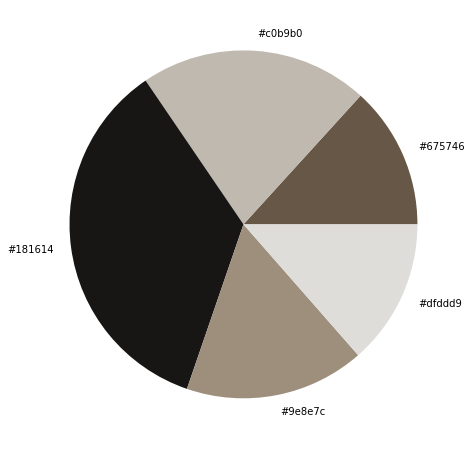

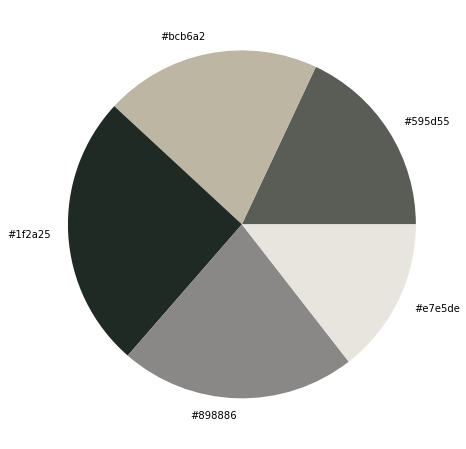

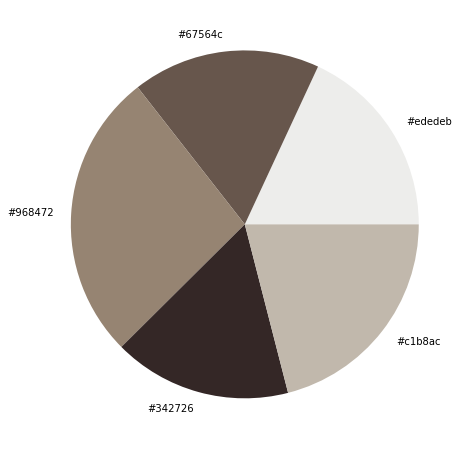

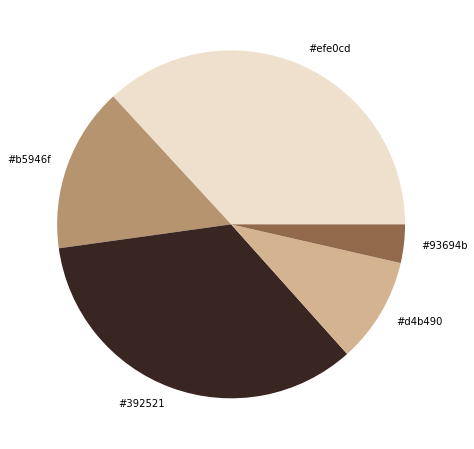

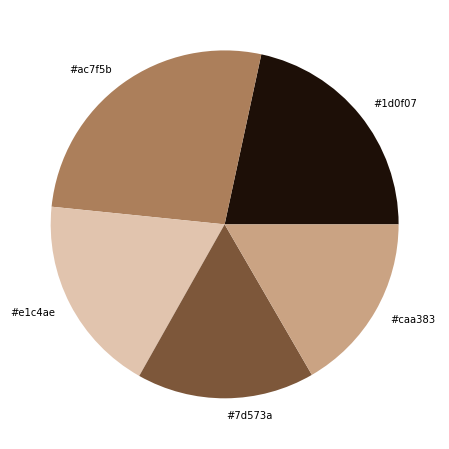

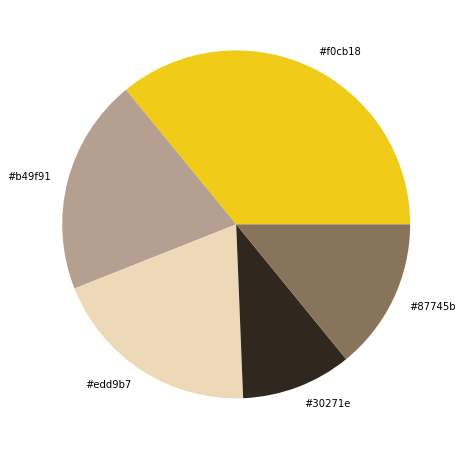

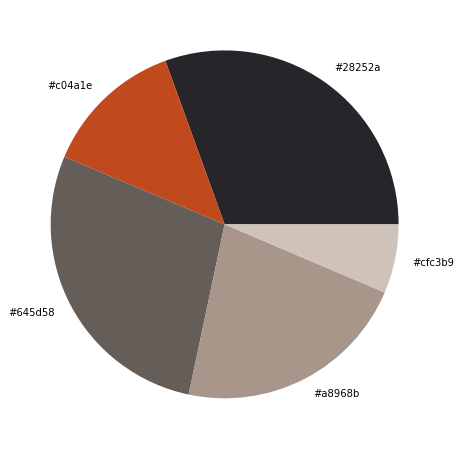

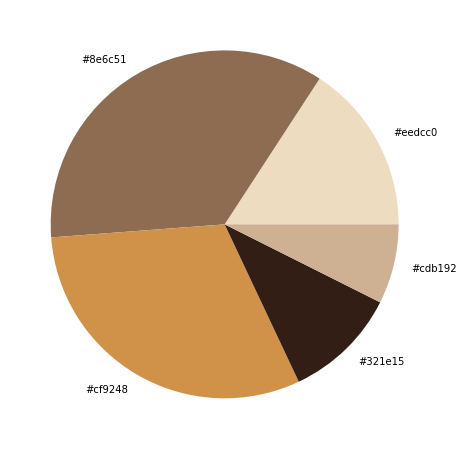

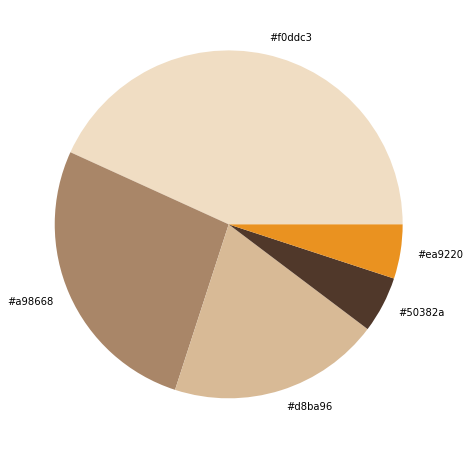

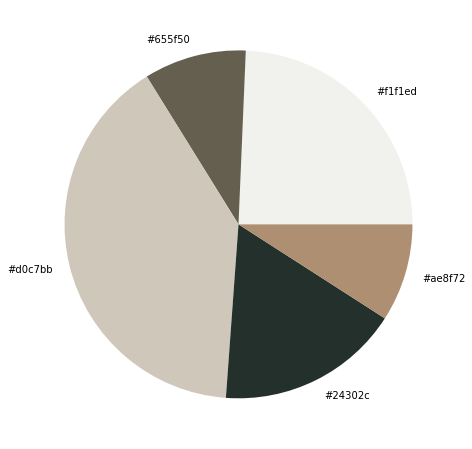

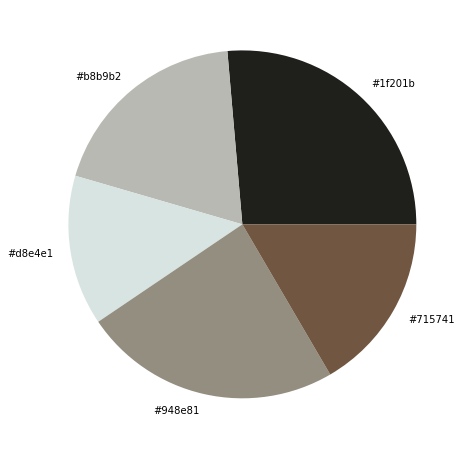

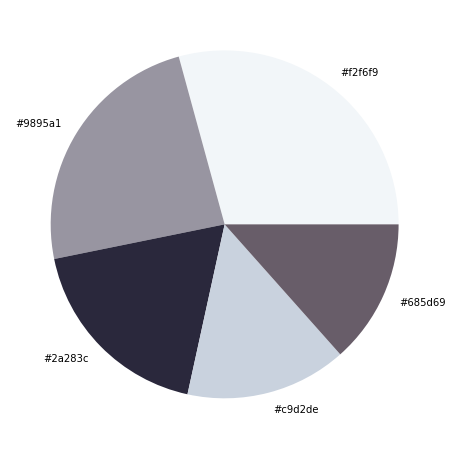

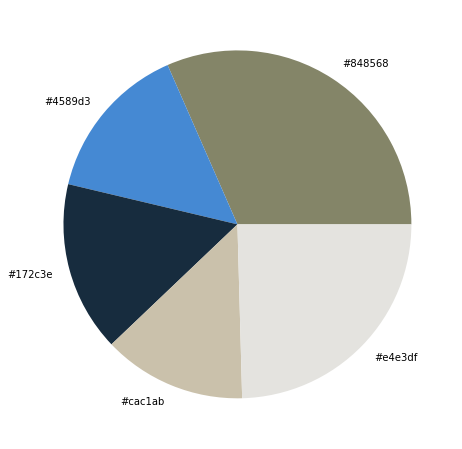

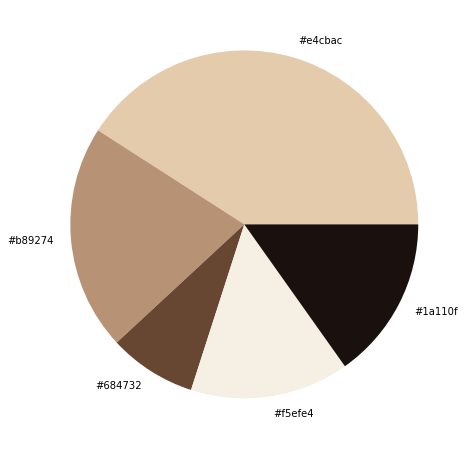

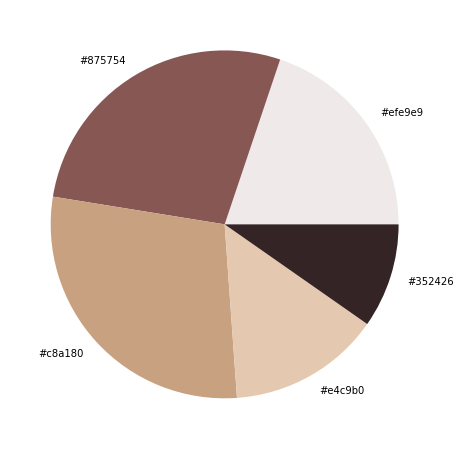

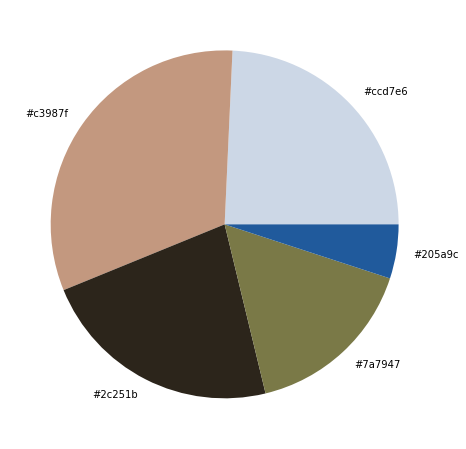

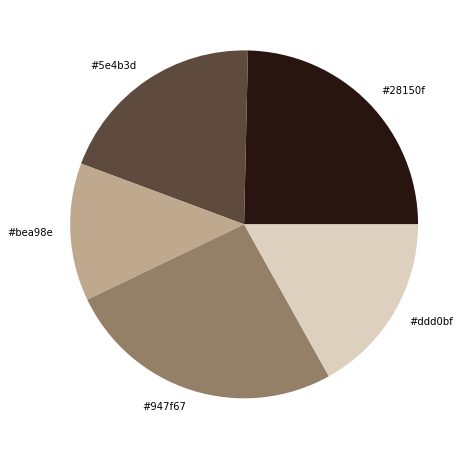

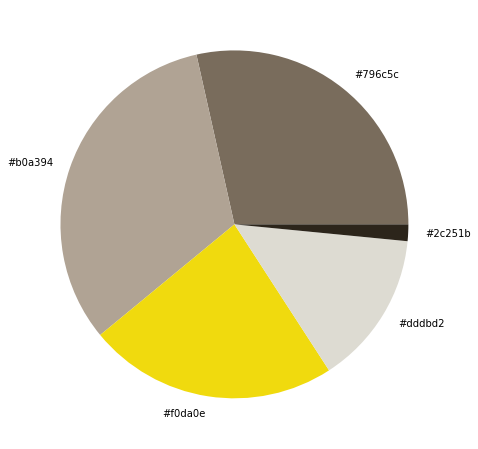

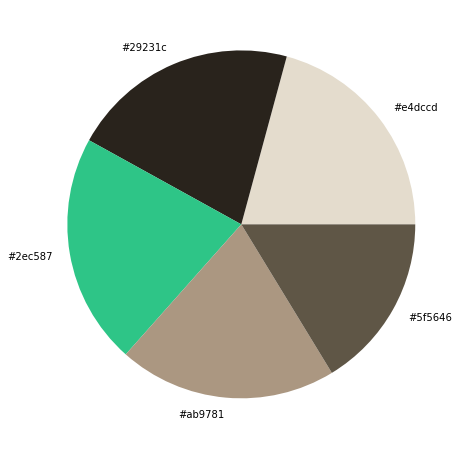

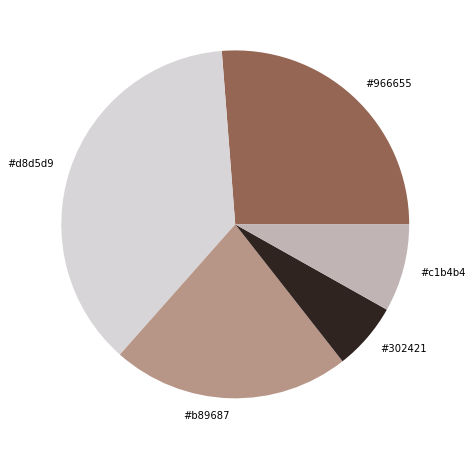

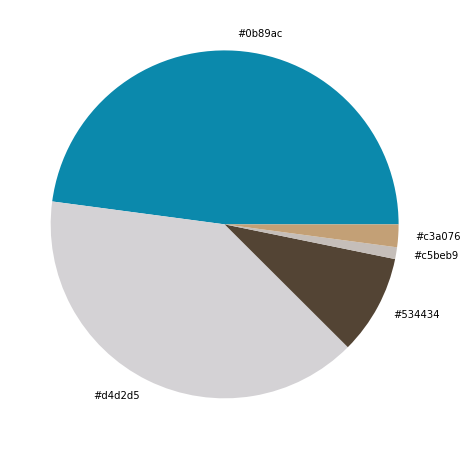

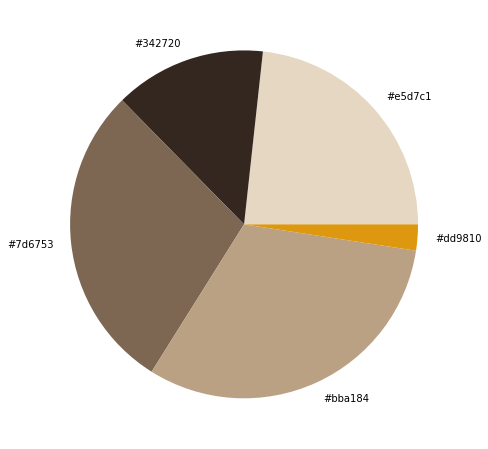

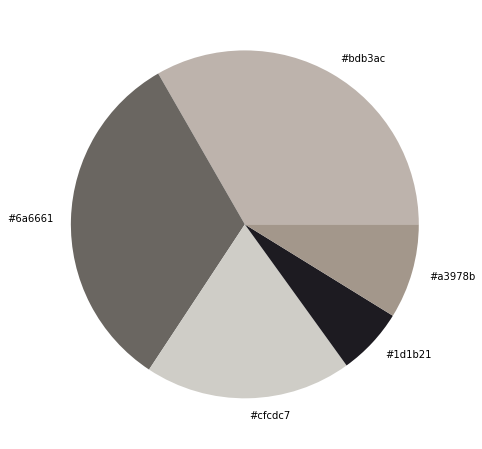

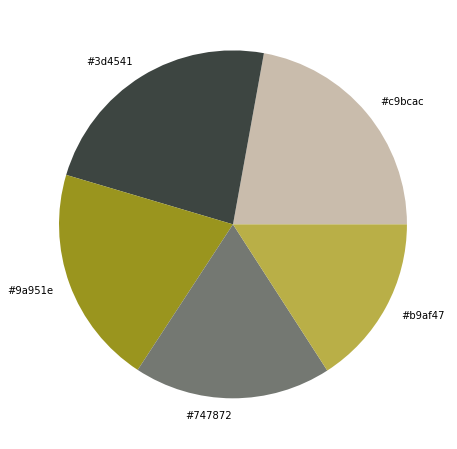

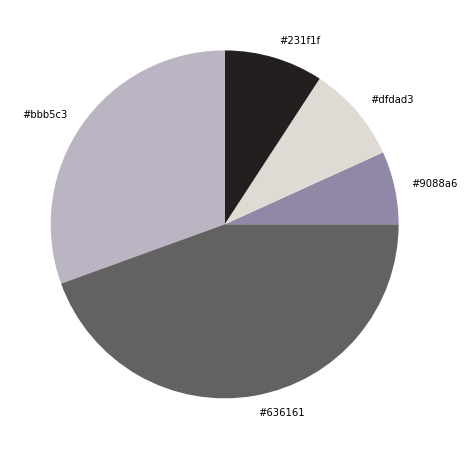

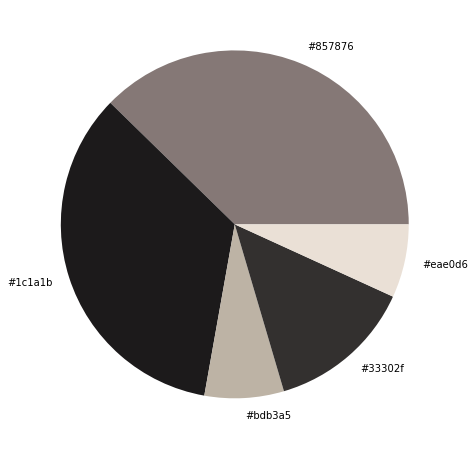

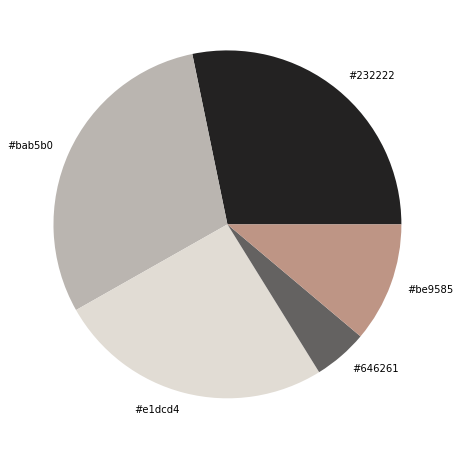

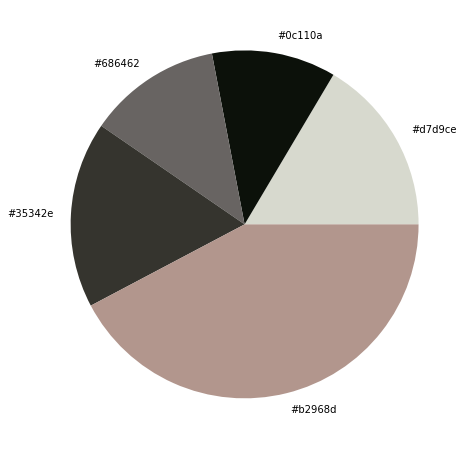

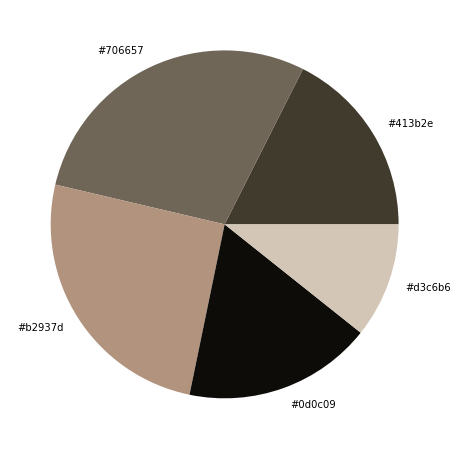

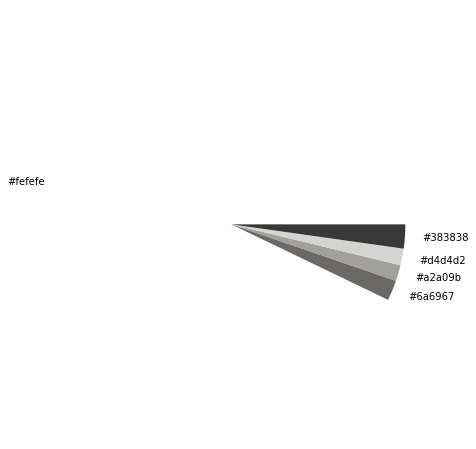

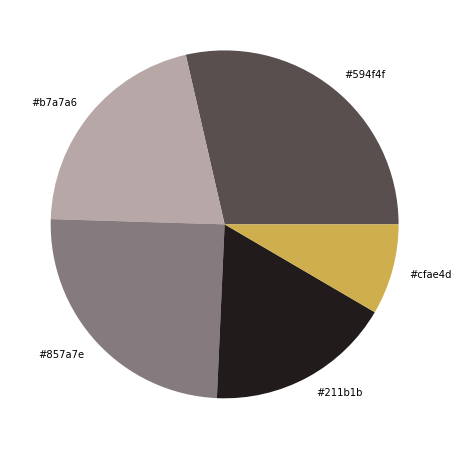

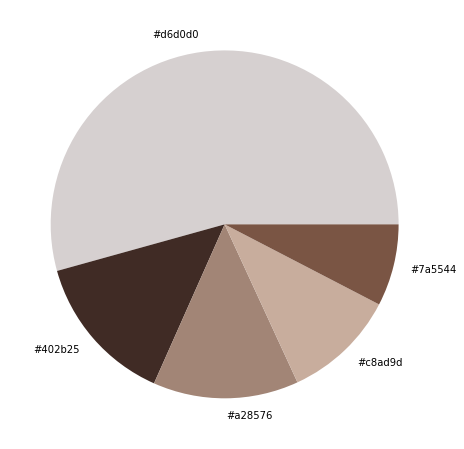

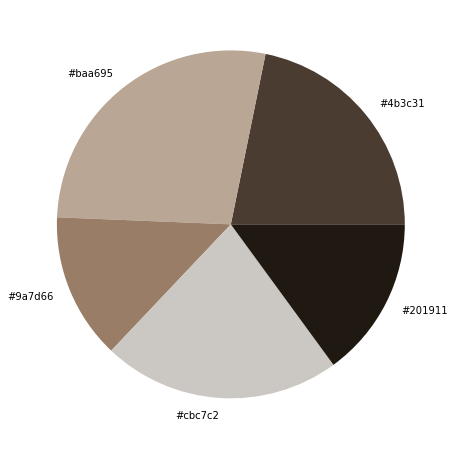

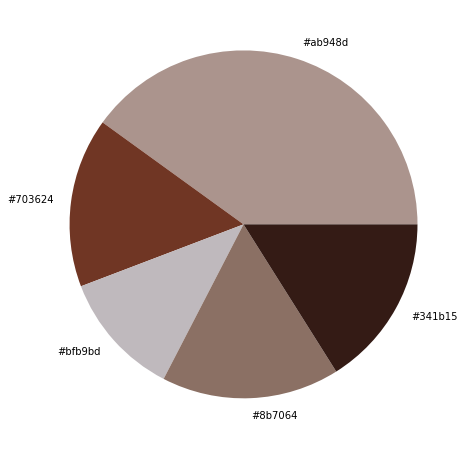

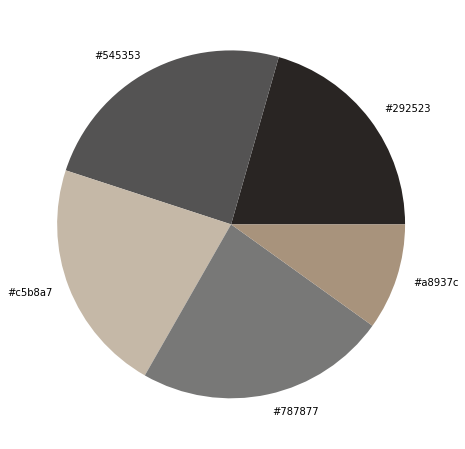

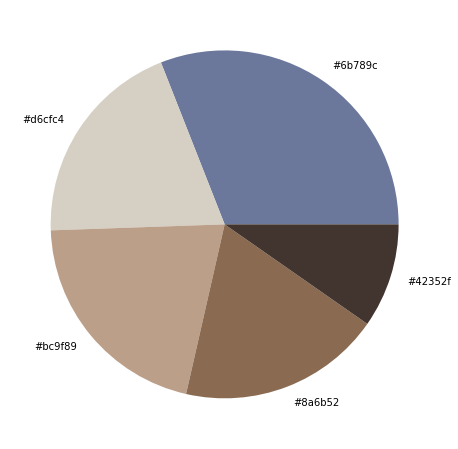

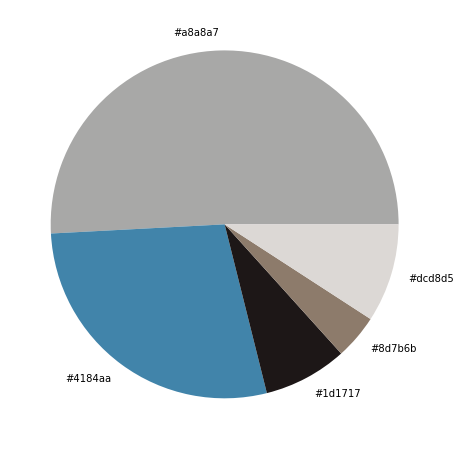

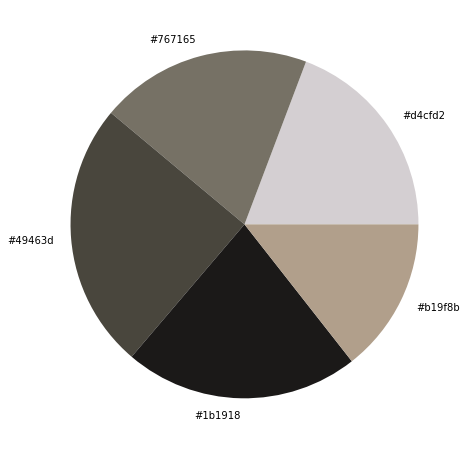

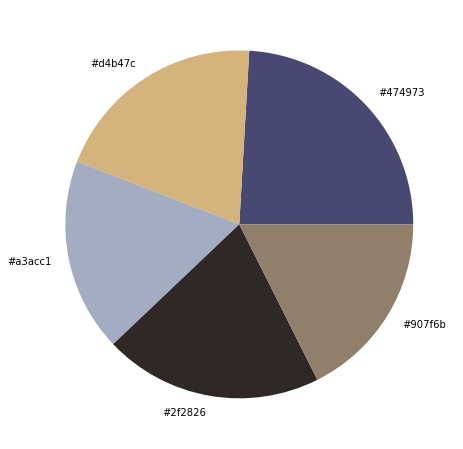

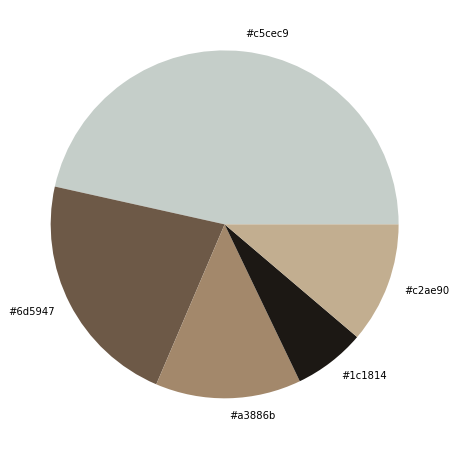

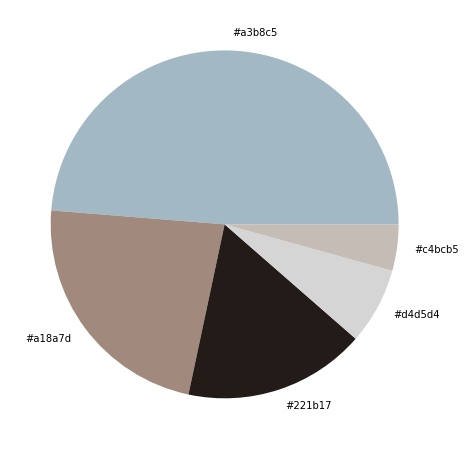

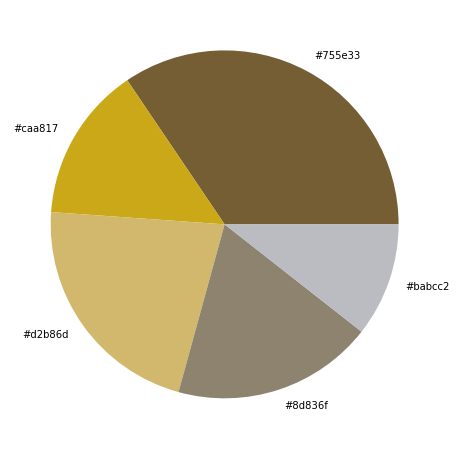

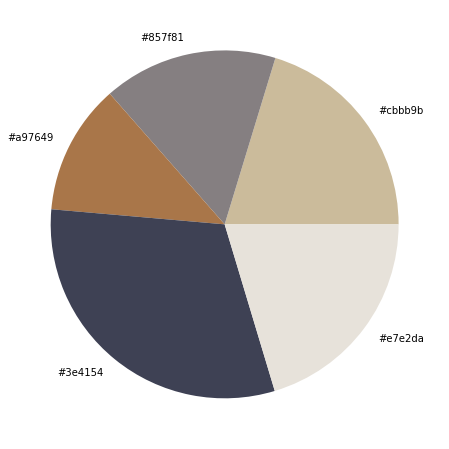

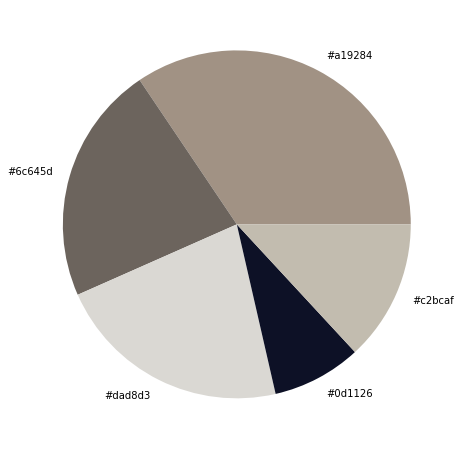

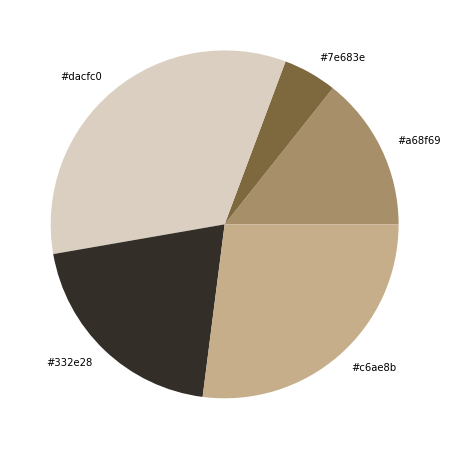

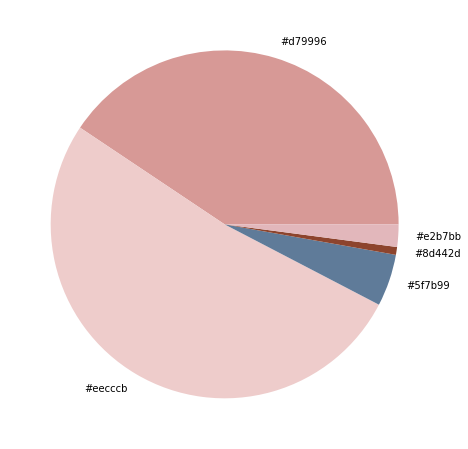

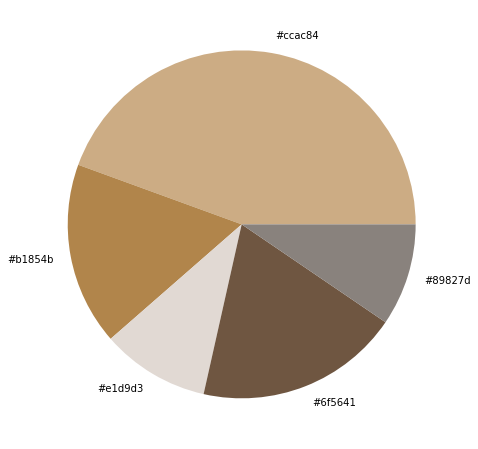

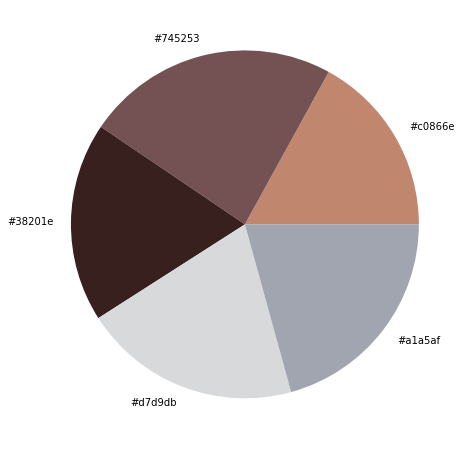

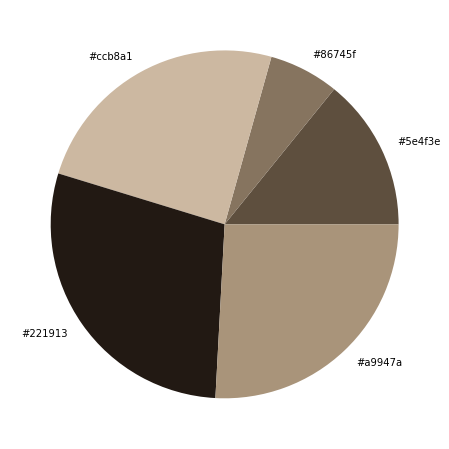

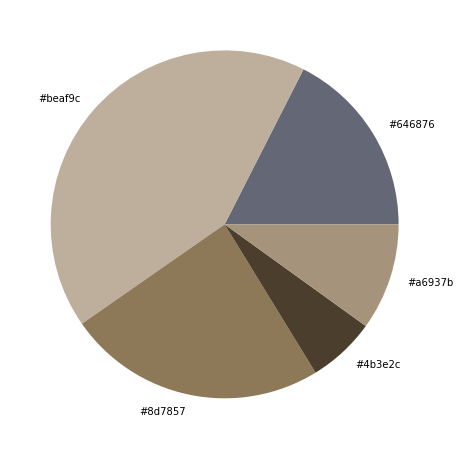

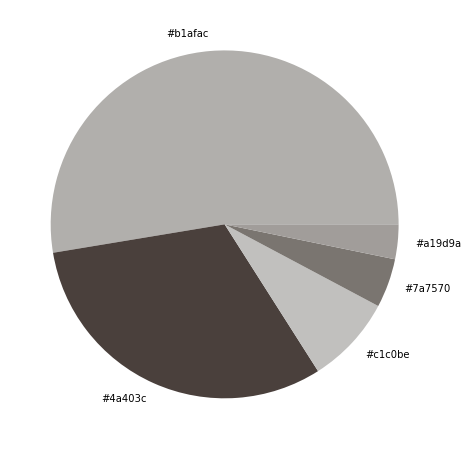

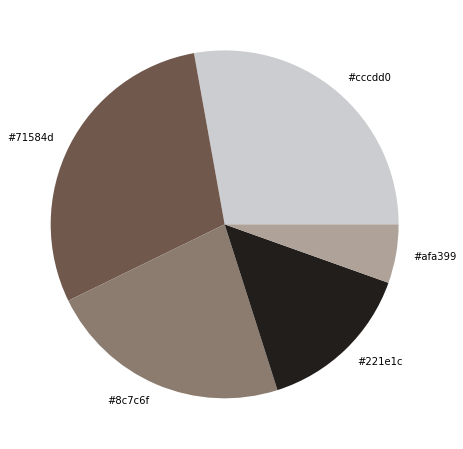

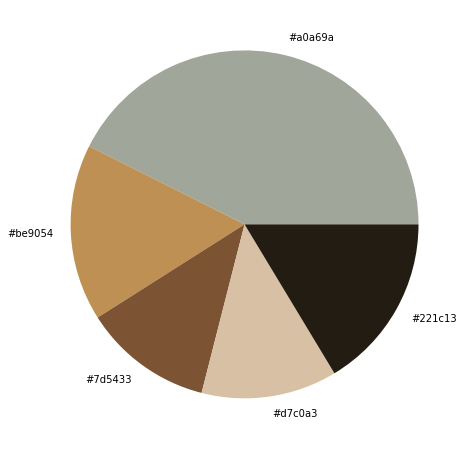

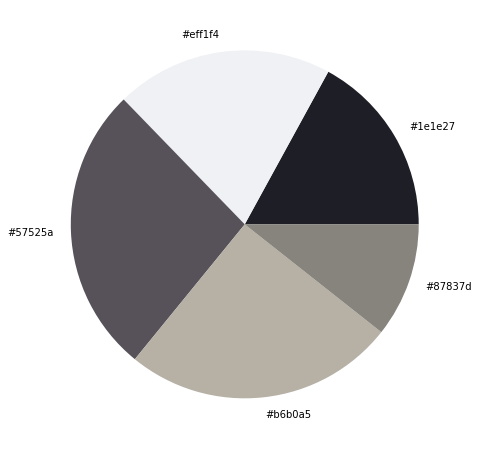

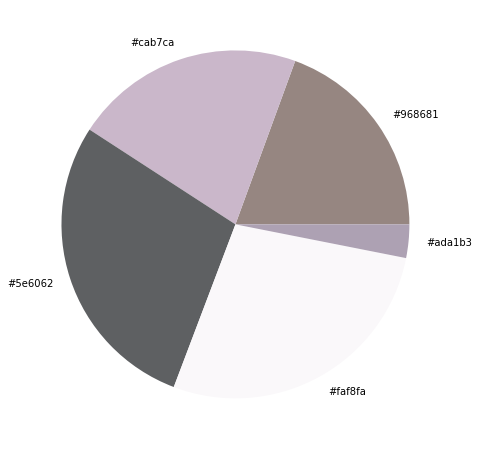

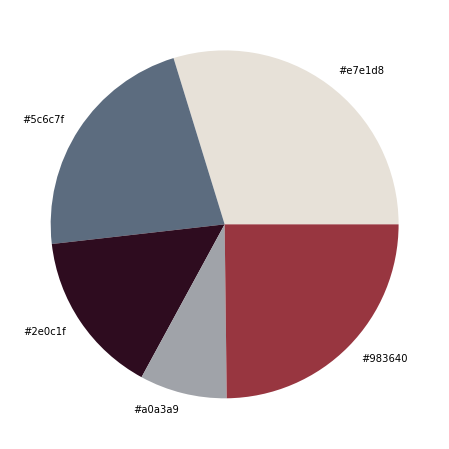

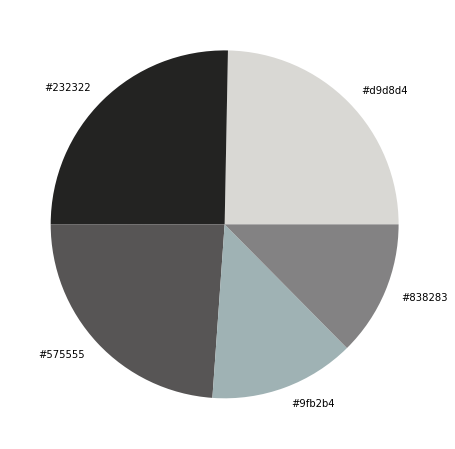

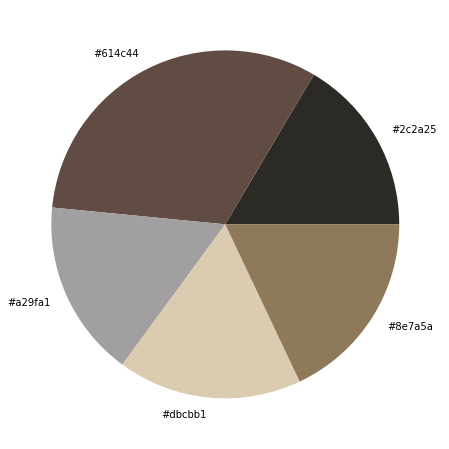

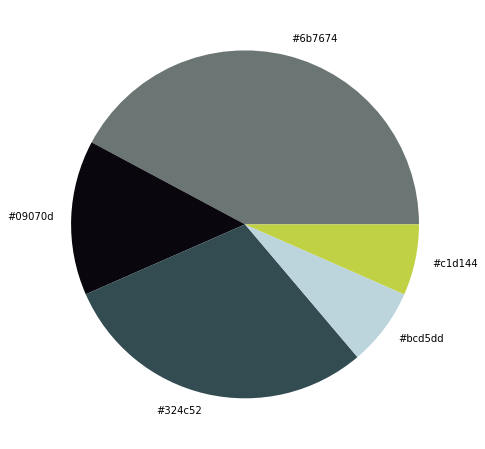

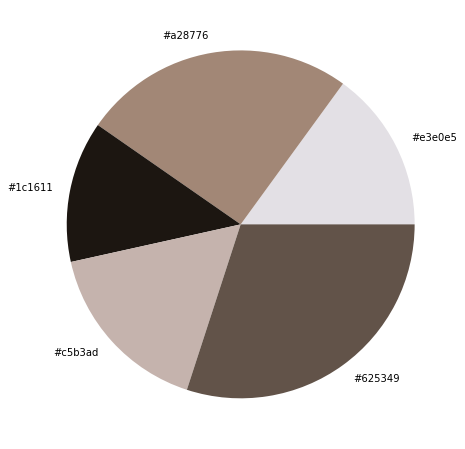

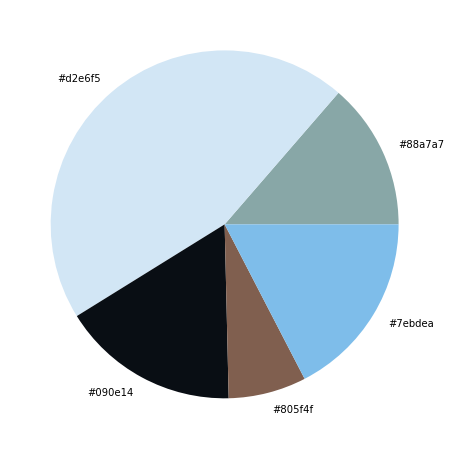

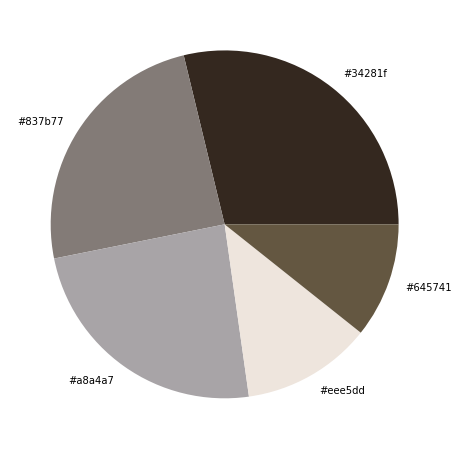

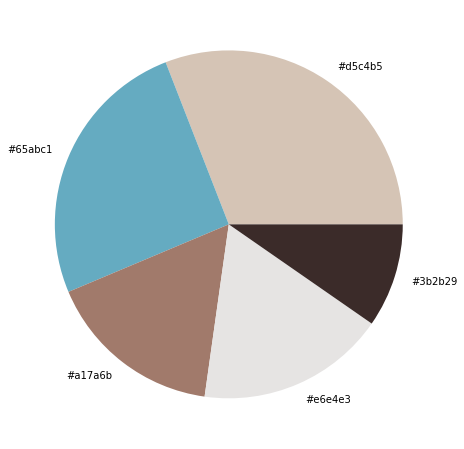

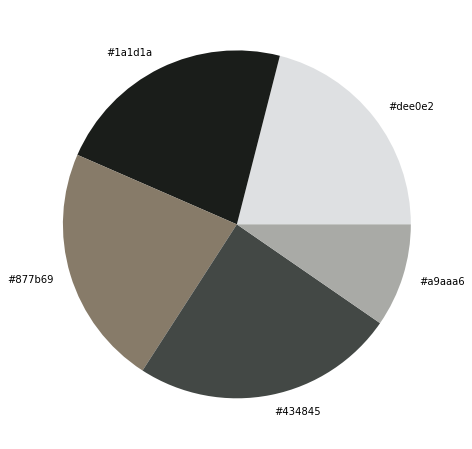

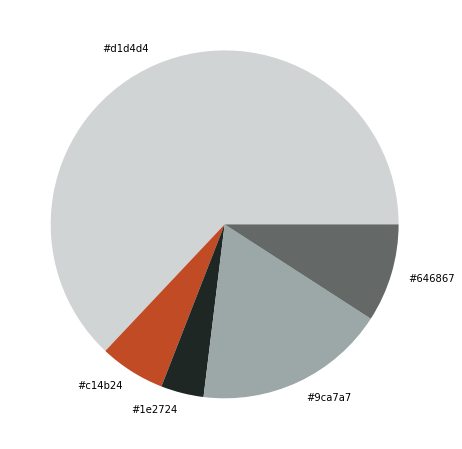

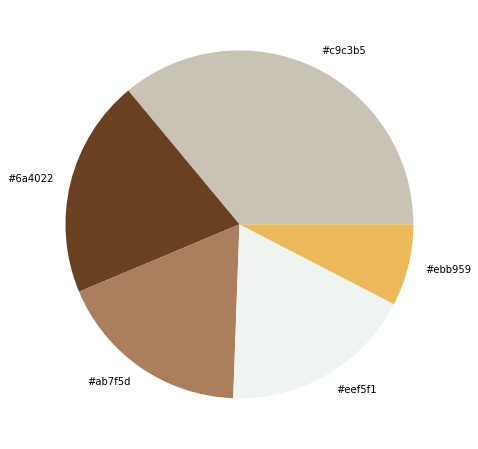

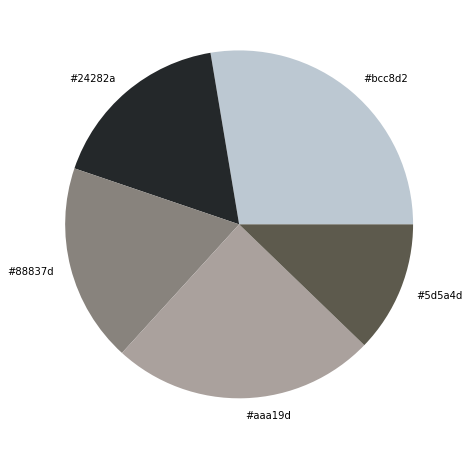

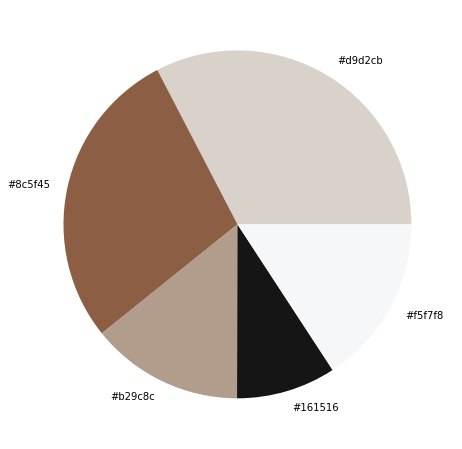

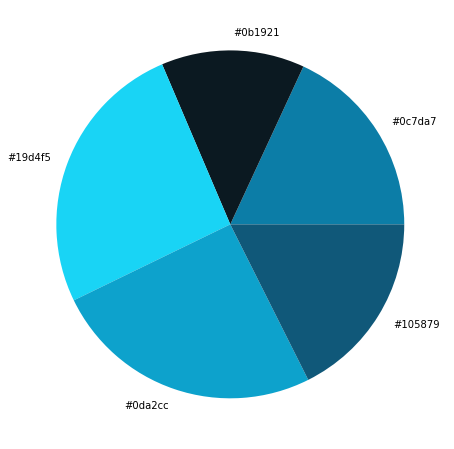

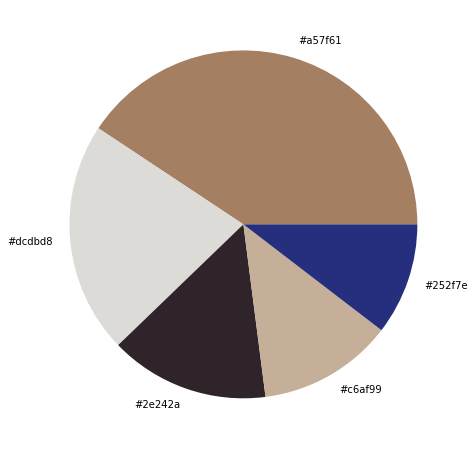

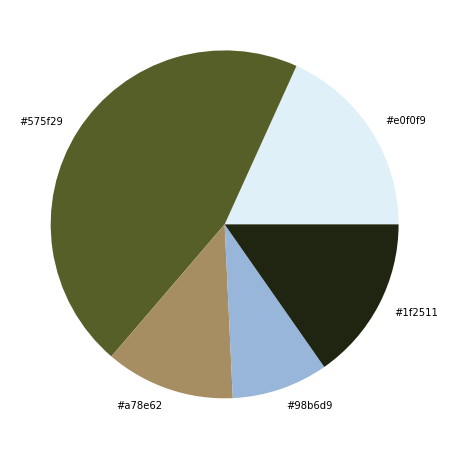

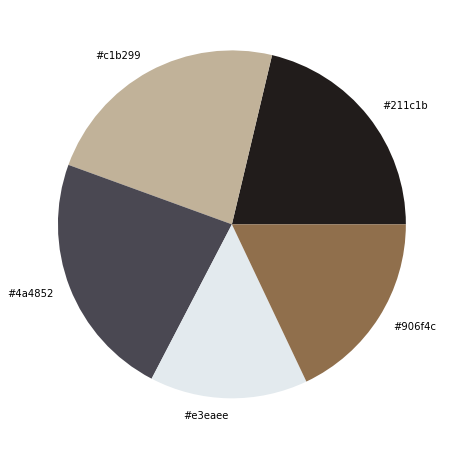

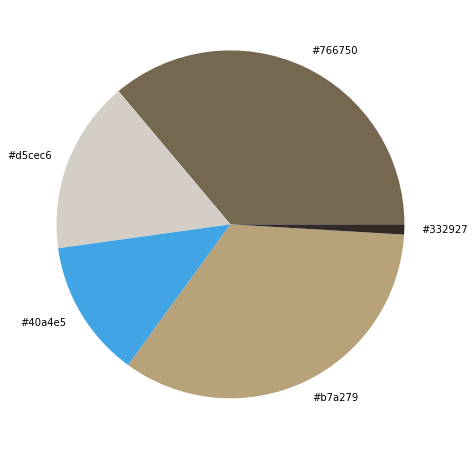

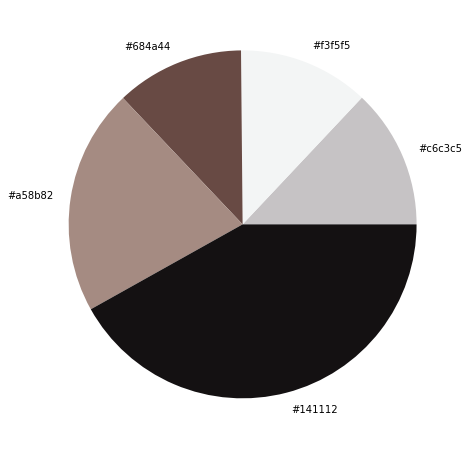

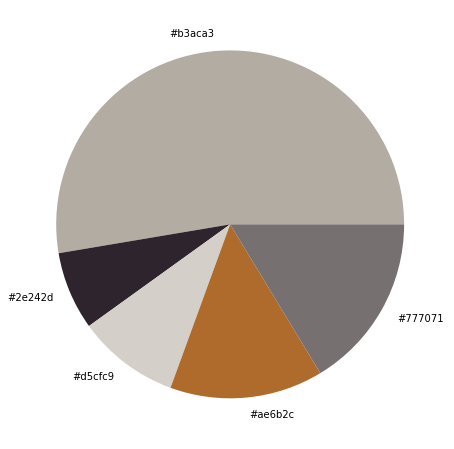

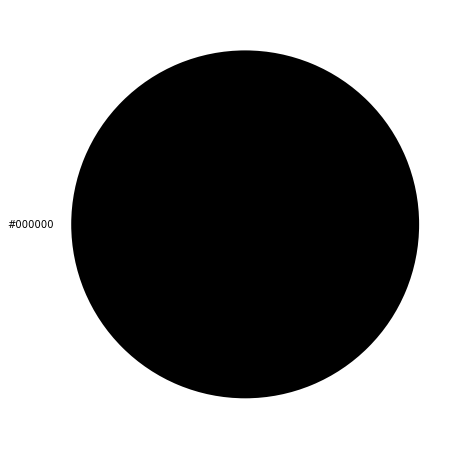

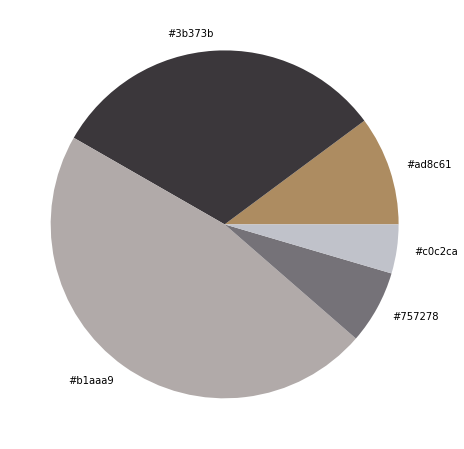

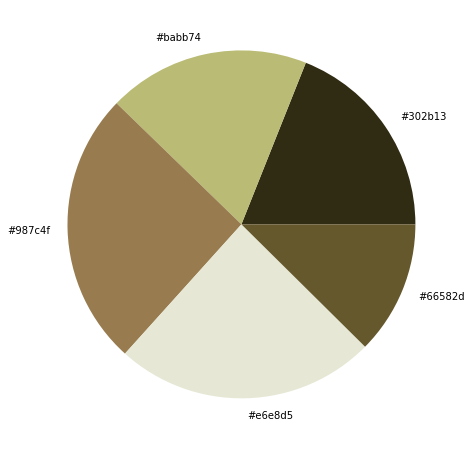

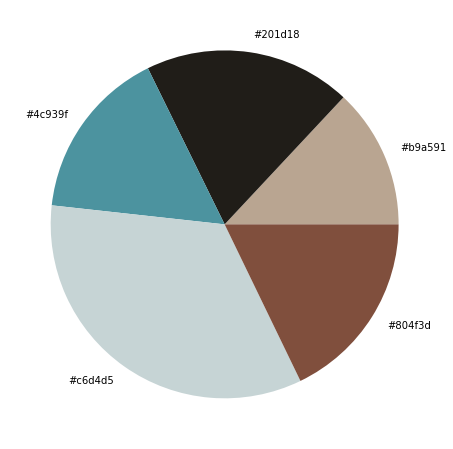

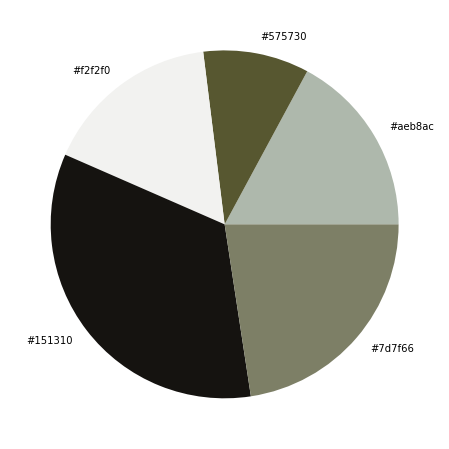

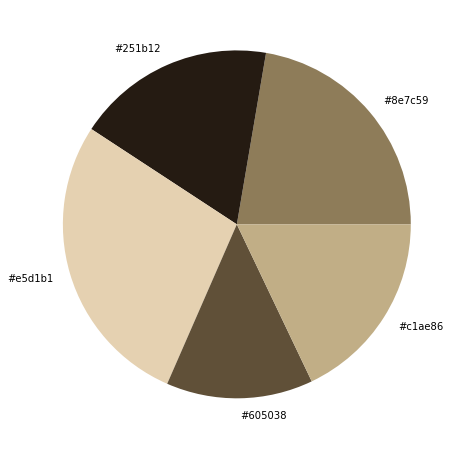

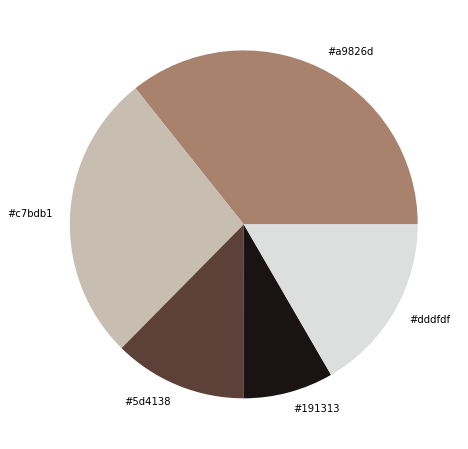

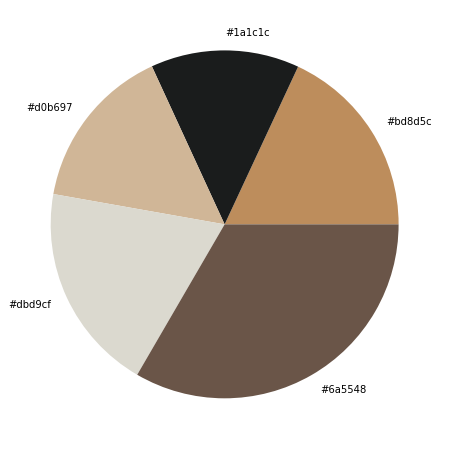

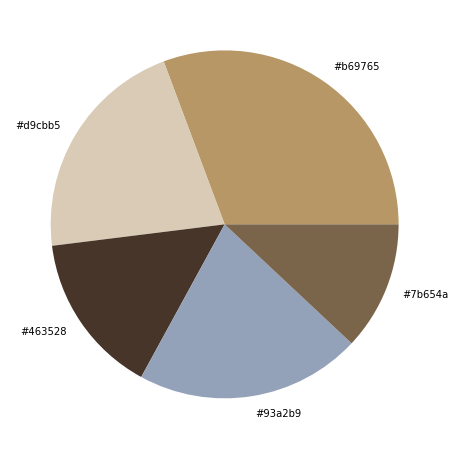

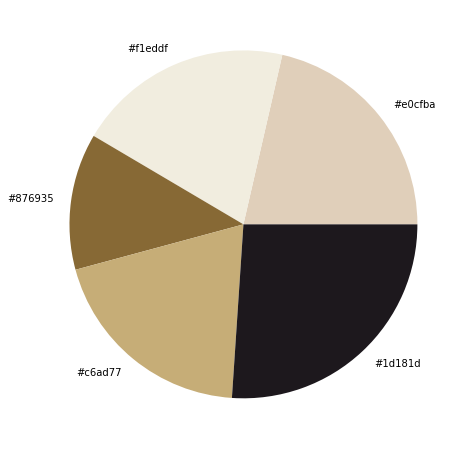

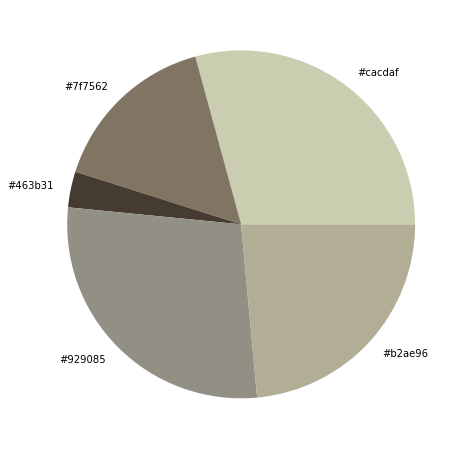

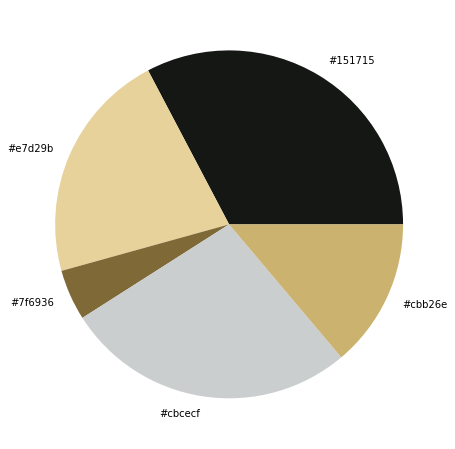

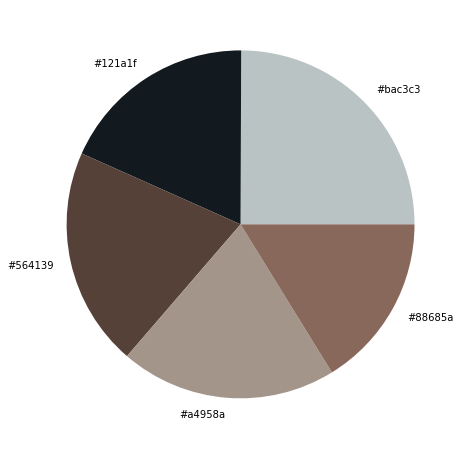

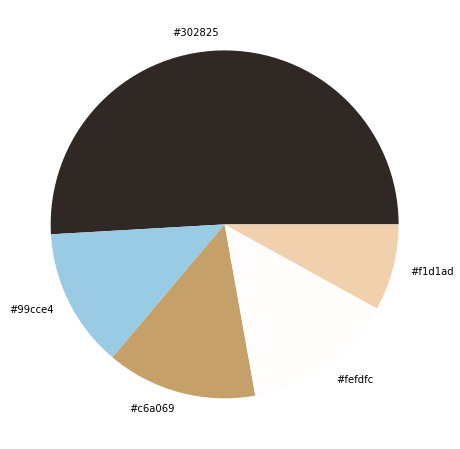

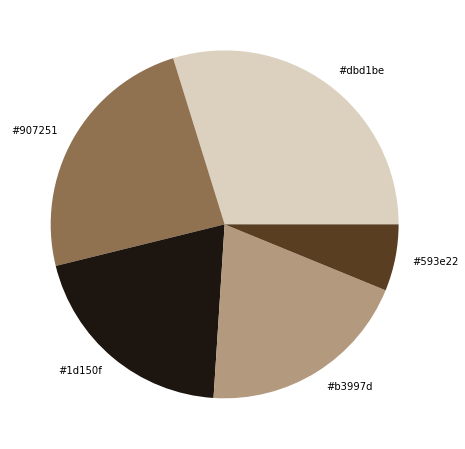

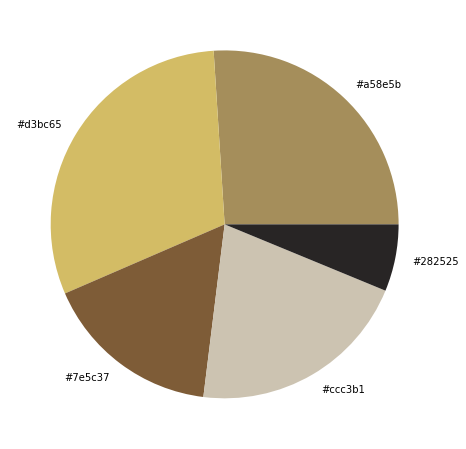

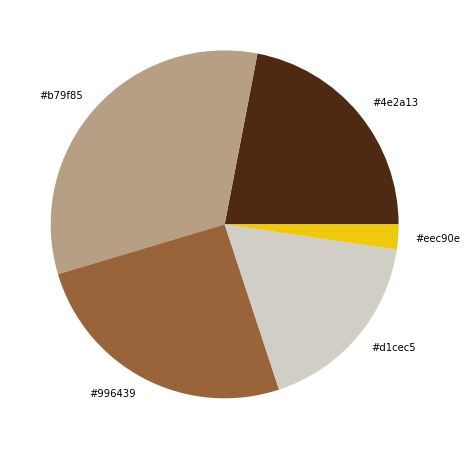

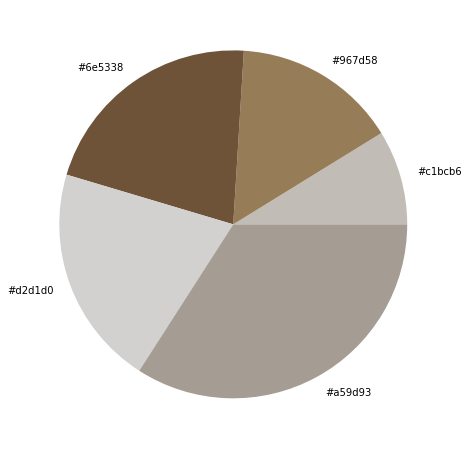

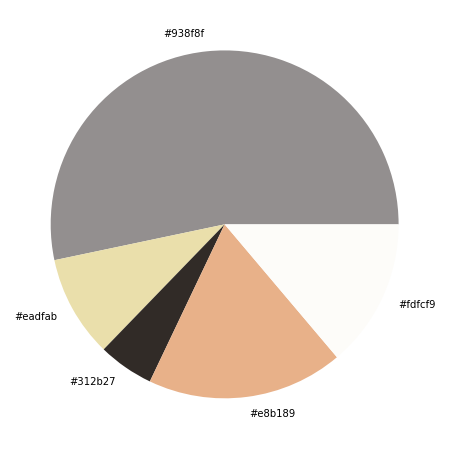

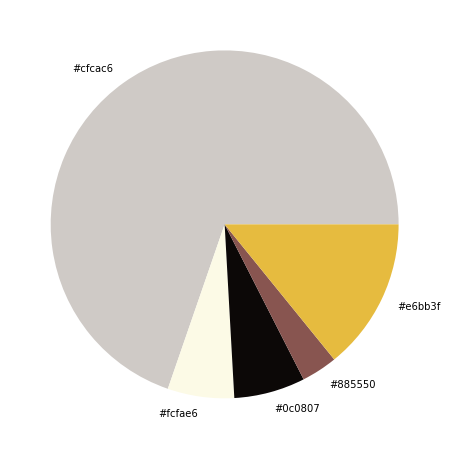

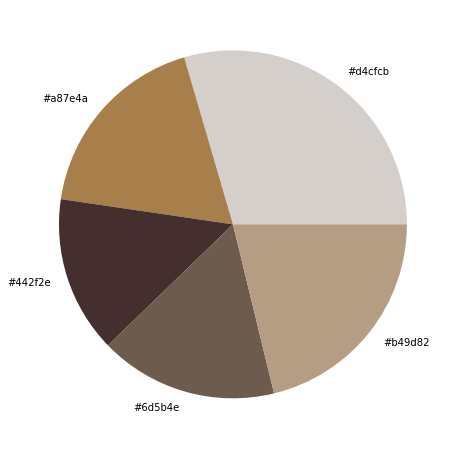

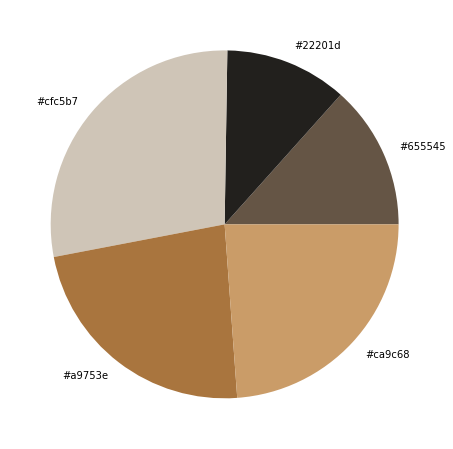

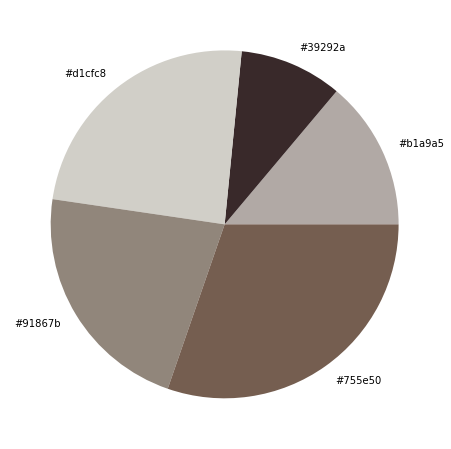

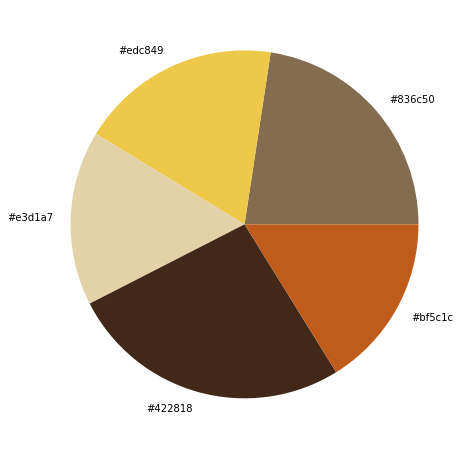

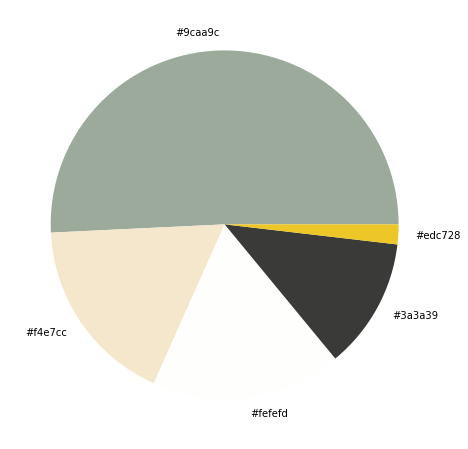

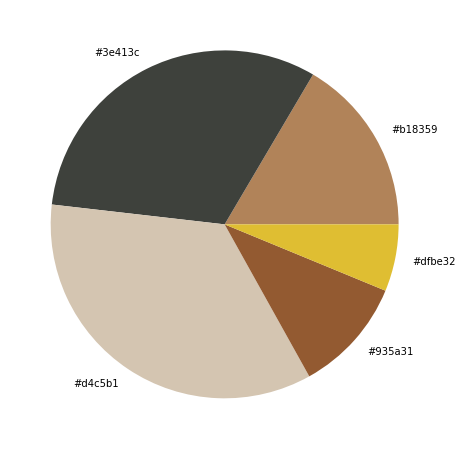

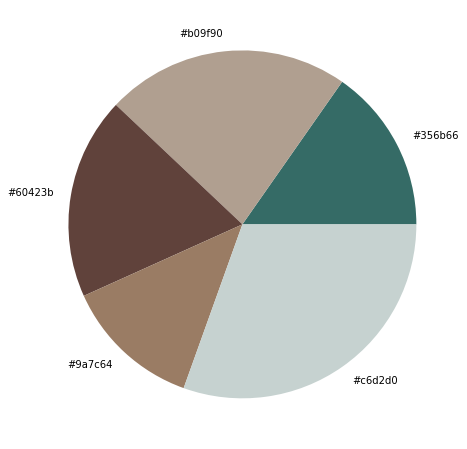

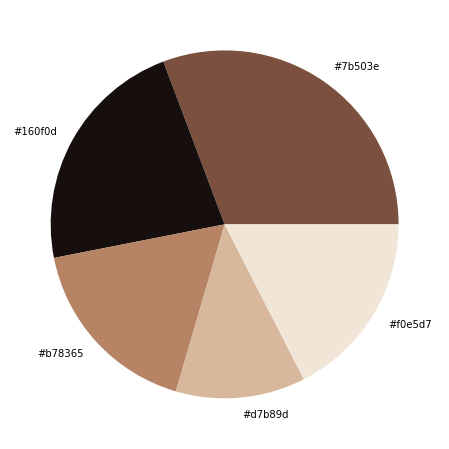

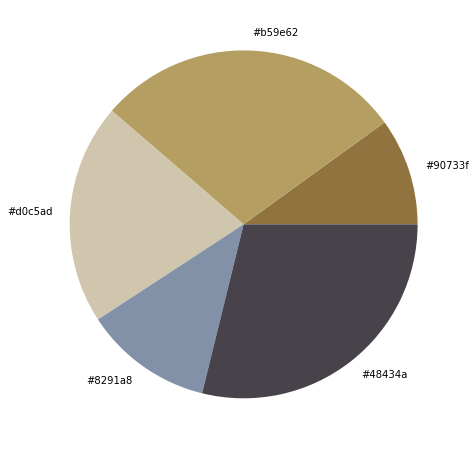

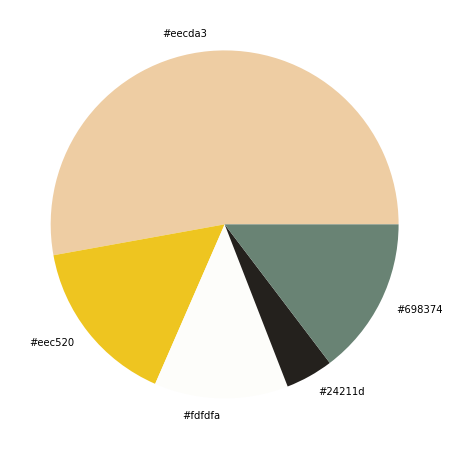

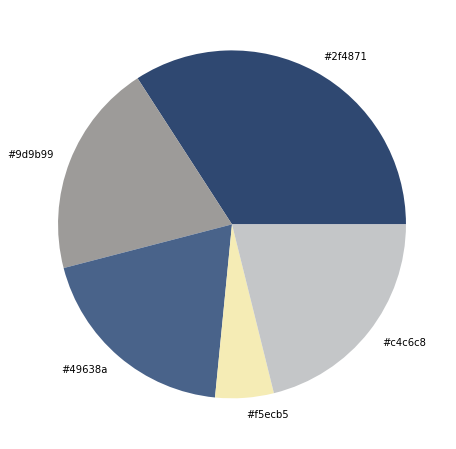

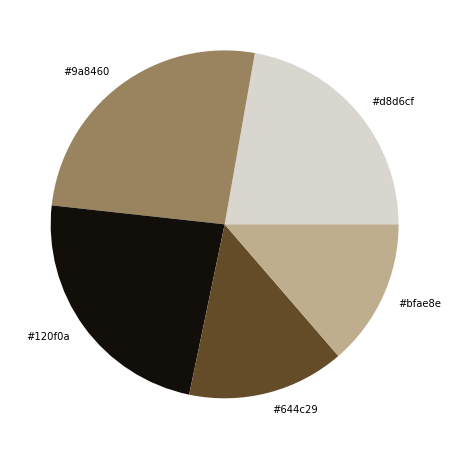

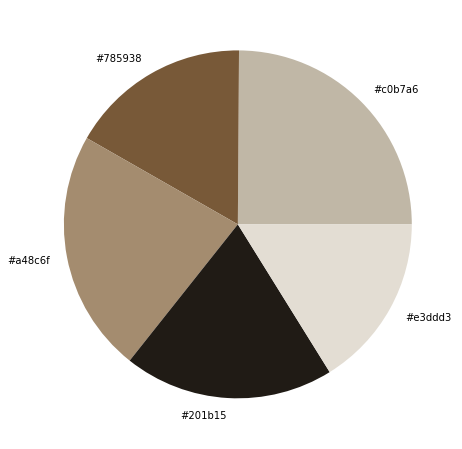

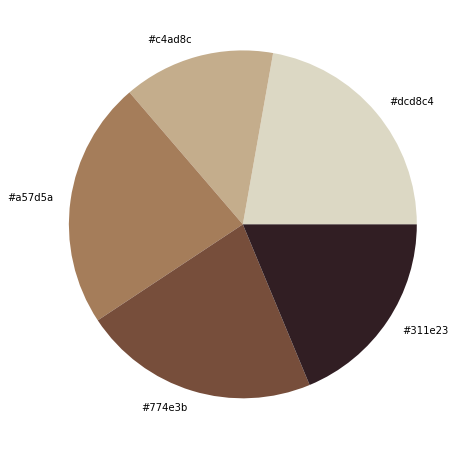

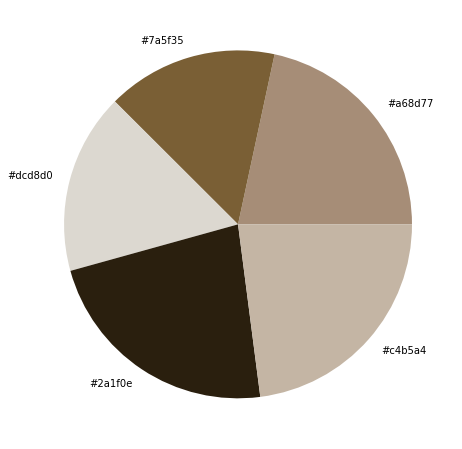

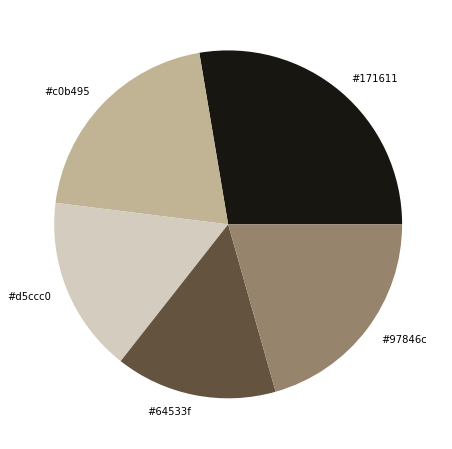

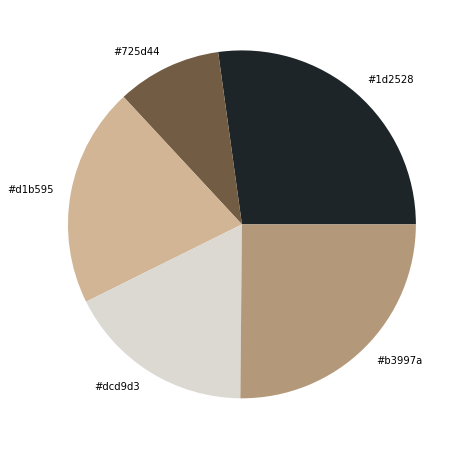

In [75]:
for ids in kol_id_list:

    img_path = r"C:\Users\pinch\Desktop\IG Crawler\Photo crawler\IG\img_"+ids
    
    # create a sub-folder
    sub_path = 'IG_Analysis/img'
    isExists = os.path.exists(sub_path+'_'+ids)
    if not isExists:
        os.makedirs(sub_path+'_'+ids)
    
    # color analysis
    for i in range(30):
        i+=1
        img_name = ids+"_"+str(i)+" .jpg"
        raw_img = cv2.imread(img_path+'\\'+img_name)
        raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
        
        img = cv2.resize(raw_img,(900,600),interpolation=cv2.INTER_AREA)
        img = img.reshape(img.shape[0]*img.shape[1],3)

        clf = KMeans(n_clusters=5)
        color_labels = clf.fit_predict(img)
        center_colors = clf.cluster_centers_

        counts = Counter(color_labels)
        ordered_colors = [center_colors[i] for i in counts.keys()]
        hex_colors = [rgb_to_hex(ordered_colors[i]) for i in counts.keys()]

        plt.figure(figsize=(12,8))
        plt.pie(counts.values(),labels = hex_colors, colors = hex_colors)
        plt.savefig("IG_Analysis\img_"+ids+"\\"+str(int(i))+" .jpg")